Branin synthetic function:

GP EI versus GP dEI (winner)

https://www.sfu.ca/~ssurjano/branin.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.9 MB/s 
     |████████████████████████████████| 872 kB 38.4 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19878 sha256=b09e989a9f45fe3b2ad901c7ab16ac8c4b91adf0009ab54ed9c557b875503ef4
  Stored in directory: /root/.cache/pip/wheels/77/da/06/166ba012a0d819a121e3f58372c668c804511875d04e16f383
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=9ad0acabc7fe0888a74dc32ccd87804210dd18cd3eb4a5986b0ed3acde57b837
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built pyGPGO Theano-PyMC


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'Branin'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'Branin':
    
    # True y bounds:
    operator = -1
    y_lb = 0.397887 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb_x1 = -5 
    ub_x1 = +10
    lb_x2 = +0 
    ub_x2 = +15

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# Test data:
    x1_test = np.linspace(lb_x1, ub_x1, n_test)
    x2_test = np.linspace(lb_x2, ub_x2, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training, a = 1, b = (5.1 / (4 * (np.pi) ** 2)), c = (5 / (np.pi)), r = 6, s = 10, t = (1 / (8 * np.pi))):
        return operator * ((a * (x2_training - b * x1_training ** 2 + c * x1_training - r) ** 2) + 
                 s * (1 - t) * np.cos(x1_training) + s)
        

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [8]:
### Surrogate derivatives: 

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [9]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [10]:
n_start_AcqFunc = max_iter
inverse = -1


In [11]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

n_start = n_start_AcqFunc

class GPGO_approx(GPGO):
  
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         GP EI: maximum y '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
  
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncApprox = -min(self.f_best)
        self.history.append(self.min_acqfuncApprox)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncApprox = self.min_acqfuncApprox
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncApprox = BOLD + OKGREEN + str(min_acqfuncApprox) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncApprox))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        GP dEI: maximum y '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncExact = -min(self.f_best)
        self.history.append(self.min_acqfuncExact) 
        
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncExact = self.min_acqfuncExact
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncExact = BOLD + OKGREEN + str(min_acqfuncExact) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncExact))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 1.25533007 10.8048674 ]	 56.52874004692151	 27.68166689936483	    
init	 [-4.99828438  4.53498859]	 172.66531086516164	 27.68166689936483	    
init	 [-2.79866164  1.38507892]	 102.58290348816024	 27.68166689936483	    
init	 [-2.20609683  5.18341091]	 28.868064601155666	 27.68166689936483	    
init	 [0.95151211 8.08225101]	 27.68166689936483	 27.68166689936483	    
1	 [8.41909995 1.27566317]	 5.089934878453152	 5.089934878453152	 27.68166688936483
2  	 [ 8.98893195 10.45227242]	 70.52424256621515	 5.089934878453152	 5.093418823776248
3	 [-3.98443869 13.27643184]	 4.856556129138367	 4.856556129138367	 5.0934173844556945
4  	 [2.90512774 0.        ]	 6.749370292693687	 4.856556129138367	 4.861548934817805
5  	 [ 5.3348007 15.       ]	 206.4244586271804	 4.856556129138367	 4.861548447489136
6  	 [5.82730156 5.65849845]	 39.28905326289761	 4.856556129138367	 4.8615376580225265
7  	 [-5.          

In [14]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [1.53992353 0.38889348]	 22.31361308916297	 6.692051508754487	    
init	 [3.24493717 6.52983589]	 19.233109967858276	 6.692051508754487	    
init	 [1.30551703 4.95502232]	 13.177851563387286	 6.692051508754487	    
init	 [-1.93027049  9.2890645 ]	 6.692051508754487	 6.692051508754487	    
init	 [-0.50517989  4.00240913]	 26.437522758780958	 6.692051508754487	    
1  	 [ 9.5587047  12.00387527]	 89.09951357262268	 6.692051508754487	 6.6922650079064745
2	 [9.59366035 1.69164323]	 1.3984593420568778	 1.3984593420568778	 6.692265007906303
3  	 [ 3.24245232 12.67669673]	 110.25694222671481	 1.3984593420568778	 1.684590944528292
4  	 [-2.58611214 14.70647972]	 15.728927661559513	 1.3984593420568778	 1.6845899705558112
5  	 [-4.49465842  0.        ]	 256.405875659363	 1.3984593420568778	 1.6845898296574207
6  	 [8.72654897 6.41265603]	 22.569095286958294	 1.3984593420568778	 1.6845797780077387
7  	 [-

In [15]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 3.26196854 10.62221734]	 71.68783452098575	 18.07886746449891	    
init	 [-0.63642892  7.66241408]	 18.07886746449891	 18.07886746449891	    
init	 [ 8.39420432 13.44439633]	 141.98653529865882	 18.07886746449891	    
init	 [-3.11622034  3.10864317]	 83.31045707266176	 18.07886746449891	    
init	 [-4.22799195  6.61214765]	 76.5294170688398	 18.07886746449891	    
1  	 [6.70472147 4.59545299]	 30.726791812855225	 18.07886746449891	 18.07886745449891
2	 [-5. 15.]	 17.508299515778166	 17.508299515778166	 18.07886745449889
3	 [2.64492238 0.66856133]	 5.661284999877455	 5.661284999877455	 17.508297558832044
4  	 [10.  0.]	 10.960889035651505	 5.661284999877455	 5.662656051008728
5  	 [ 0.17572036 15.        ]	 105.49246408403764	 5.661284999877455	 5.66262342313561
6  	 [10.          8.34438297]	 30.473976245890775	 5.661284999877455	 5.66255426689693
7  	 [-0.6195202  11.33294215]	 36.2849610652

In [16]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [9.50544759 8.20848374]	 32.51676744781521	 7.247126865776948	    
init	 [ 9.5902654  10.72223991]	 66.20566674364716	 7.247126865776948	    
init	 [5.46593237 3.24134243]	 20.90089401680587	 7.247126865776948	    
init	 [9.64411682 0.09345383]	 7.247126865776948	 7.247126865776948	    
init	 [-1.20526456  6.52187299]	 15.941376982363263	 7.247126865776948	    
1  	 [ 1.25164457 13.57001383]	 100.61648848019335	 7.247126865776948	 7.247197909829161
2  	 [-4.27198795  1.64727177]	 188.41076037632916	 7.247126865776948	 7.247197409325942
3  	 [-4.64886205 10.90918479]	 37.28607541173125	 7.247126865776948	 7.2471964679364484
4  	 [3.91133965 8.49906097]	 48.63781804318897	 7.247126865776948	 7.247185995789564
5  	 [1.2501607 0.       ]	 30.769010850910195	 7.247126865776948	 7.24718455727612
6  	 [ 6.50670021 15.        ]	 212.1962305407001	 7.247126865776948	 7.247149675349752
7	 [10.         3.

In [17]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-1.67010243 13.06098459]	 25.390690545664548	 25.311309190989615	    
init	 [-1.89921267 13.77916362]	 25.311309190989615	 25.311309190989615	    
init	 [2.32616783 9.17615794]	 41.60147975414021	 25.311309190989615	    
init	 [6.48861785 7.77626982]	 63.81281921768236	 25.311309190989615	    
init	 [-0.54799248  2.81581843]	 34.966203644931994	 25.311309190989615	    
1	 [8.84124421 0.03321319]	 5.96108856337545	 5.96108856337545	 25.311309180989422
2  	 [ 8.39476442 14.47736321]	 167.21523769473345	 5.96108856337545	 5.961907098265746
3  	 [-4.14019794  7.24510313]	 61.933263744898504	 5.96108856337545	 5.961905563429438
4  	 [-5.  0.]	 308.12909601160663	 5.96108856337545	 5.961890642882623
5  	 [3.90128236 0.        ]	 6.125408773900473	 5.96108856337545	 5.961875502097774
6  	 [ 3.02984949 15.        ]	 160.13241058768565	 5.96108856337545	 5.961819900376904
7	 [10.          4.33672865]	 

In [18]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [8.39290227 4.97969708]	 15.553860636684597	 15.31731051317483	    
init	 [7.31843685 0.62544939]	 15.31731051317483	 15.31731051317483	    
init	 [-3.3851498   8.92578096]	 16.222288919361837	 15.31731051317483	    
init	 [2.94726043 6.28211143]	 15.406373581304088	 15.31731051317483	    
init	 [0.03111774 9.33779148]	 31.07053245856209	 15.31731051317483	    
1  	 [ 9.64829531 12.55362889]	 98.32295673962142	 15.31731051317483	 15.317310503173594
2  	 [-1.22578785  0.62063252]	 69.8637190838968	 15.31731051317483	 15.317310503035172
3  	 [ 4.11366061 15.        ]	 183.1048464690602	 15.31731051317483	 15.317309952766703
4	 [-2.66581011 14.57032849]	 13.089071799586758	 13.089071799586758	 15.317309277235875
5  	 [-5.          4.21692696]	 180.95588650406685	 13.089071799586758	 13.088994339731487
6  	 [5.44159957 9.98675116]	 94.22614246906714	 13.089071799586758	 13.088312535647159
7	 [3.238

In [19]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-3.85537566 11.69878188]	 8.299317850233932	 5.211335324193094	    
init	 [ 1.57613847 10.85197767]	 59.50408380701259	 5.211335324193094	    
init	 [9.66984268 8.07743806]	 29.714921414987273	 5.211335324193094	    
init	 [2.51680695 1.080767  ]	 5.211335324193094	 5.211335324193094	    
init	 [-0.9734153   7.49823751]	 15.431057204948033	 5.211335324193094	    
1  	 [-4.97859679  1.38393519]	 260.3293952774437	 5.211335324193094	 5.214210673253922
2  	 [ 7.42679792 14.12713902]	 178.37635728719692	 5.211335324193094	 5.214210654642059
3  	 [8.08940775 0.35854539]	 9.249625108410735	 5.211335324193094	 5.214210312347393
4  	 [-3.39684884  5.54228873]	 54.79871094423047	 5.211335324193094	 5.214210673253922
5  	 [4.5745799  5.89625789]	 28.693235382945684	 5.211335324193094	 5.214202666027069
6  	 [-0.88571854 15.        ]	 72.16055111056878	 5.211335324193094	 5.2137320951930075
7	 [10.      

In [20]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 8.10144104 14.52810994]	 175.17297136347514	 15.416245468470875	    
init	 [8.0379181  7.96283537]	 49.32173799887473	 15.416245468470875	    
init	 [-1.50907508  0.17098206]	 83.26753461673219	 15.416245468470875	    
init	 [1.45703227 6.0352704 ]	 15.416245468470875	 15.416245468470875	    
init	 [2.84012007 7.17587694]	 22.49093277852639	 15.416245468470875	    
1	 [9.77124156 0.43098073]	 6.499298445992174	 6.499298445992174	 15.416245458468238
2  	 [-4.87537438 11.82874897]	 36.57081146531108	 6.499298445992174	 6.499606274426392
3  	 [ 1.38233826 12.68601766]	 86.43509303241686	 6.499298445992174	 6.499605297753907
4  	 [-5.         4.9331771]	 162.88875202992193	 6.499298445992174	 6.499605152622068
5  	 [4.45960766 1.26264545]	 7.642172669057232	 6.499298445992174	 6.499603233850996
6  	 [-1.7162825   8.75518795]	 8.735318519291516	 6.499298445992174	 6.496930753394357
7  	 [7.6181215

In [21]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-4.84438769  7.52811888]	 96.15564306553264	 3.4640248583909496	    
init	 [2.4365994  2.00744293]	 3.4640248583909496	 3.4640248583909496	    
init	 [-2.86833372  3.27838013]	 70.46930174488207	 3.4640248583909496	    
init	 [1.27762271 3.72151753]	 12.982825924833865	 3.4640248583909496	    
init	 [-3.73910523  5.1824796 ]	 75.58547400560856	 3.4640248583909496	    
1  	 [ 7.05609655 14.75038872]	 200.4388688685465	 3.4640248583909496	 3.497841782110876
2  	 [-0.46054038 14.56197292]	 79.4666617606301	 3.4640248583909496	 3.4978417820600054
3  	 [8.28747407 1.2035024 ]	 6.196385269800155	 3.4640248583909496	 3.497841747459437
4  	 [7.59811302 8.71517261]	 66.45196249675806	 3.4640248583909496	 3.4978407603382
5  	 [1.75712256 9.14412423]	 38.93294557365744	 3.4640248583909496	 3.49783700809622
6  	 [-5.        12.6760437]	 33.07572996559651	 3.4640248583909496	 3.4975471020890225
7  	 [5.671

In [22]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [6.56980965 0.31127924]	 19.863985024602144	 2.710610964564512	    
init	 [ 4.50472352 11.23205824]	 103.66999147252169	 2.710610964564512	    
init	 [2.47760518 3.37194968]	 2.710610964564512	 2.710610964564512	    
init	 [-2.02905703 11.40796068]	 8.463930835255017	 2.710610964564512	    
init	 [-2.46333745  1.32509721]	 90.49481266026973	 2.710610964564512	    
1  	 [ 9.16391068 14.81438212]	 158.2412724465548	 2.710610964564512	 2.791471383796652
2  	 [9.65621089 6.61160737]	 16.1339423373336	 2.710610964564512	 2.7914713837968415
3  	 [-3.43070383  6.59407857]	 41.58407101130534	 2.710610964564512	 2.7914713830067637
4  	 [ 1.02022796 14.99263201]	 124.89402405246402	 2.710610964564512	 2.791469993641612
5  	 [-5. 15.]	 17.508299515778166	 2.710610964564512	 2.791396791464147
6  	 [1.3076529  7.43245455]	 23.339868796515702	 2.710610964564512	 2.7909150753205063
7  	 [5.49081833 5.84072721

In [23]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-2.29595467  0.29212862]	 104.49282729548965	 22.37435843952312	    
init	 [ 1.9482779  10.87400894]	 62.47758067812407	 22.37435843952312	    
init	 [1.30305407 7.28140647]	 22.37435843952312	 22.37435843952312	    
init	 [-4.80828778  7.31057411]	 97.94503054415523	 22.37435843952312	    
init	 [ 9.12709979 12.76192634]	 111.62900800771942	 22.37435843952312	    
1	 [6.94653631 0.95529646]	 17.615403152614682	 17.615403152614682	 22.374358429523117
2	 [9.97230855 6.82110601]	 16.589650805576685	 16.589650805576685	 17.615402292780683
3  	 [-5. 15.]	 17.508299515778166	 16.589650805576685	 16.58965079556952
4	 [2.40781929 2.48994243]	 3.051168412611748	 3.051168412611748	 16.589423570025154
5  	 [ 4.54061416 15.        ]	 192.31887539788474	 3.051168412611748	 3.106127517221562
6  	 [5.60602918 5.53130859]	 36.78743781050825	 3.051168412611748	 3.105807088249035
7  	 [-0.5430178 15.       ]	 

In [24]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-2.68755736 11.10074545]	 1.3827702760021356	 0.5499315281120278	    
init	 [-1.05027477  8.0060909 ]	 14.81231853080056	 0.5499315281120278	    
init	 [-4.78137556 13.78120512]	 18.401131000214548	 0.5499315281120278	    
init	 [8.51072281 0.50132141]	 5.855172364344769	 0.5499315281120278	    
init	 [9.35424004 2.05813982]	 0.5499315281120278	 0.5499315281120278	    
1  	 [10.          4.42353593]	 3.9611862792252275	 0.5499315281120278	 1.1032403857304094
2  	 [ 8.50155249 13.79797306]	 148.00655208378976	 0.5499315281120278	 1.1028242099285575
3  	 [-4.8799499   0.15657603]	 290.0404981832191	 0.5499315281120278	 1.1028242099285575
4  	 [5.82026378 8.50131991]	 73.17953807026612	 0.5499315281120278	 1.1028231615217545
5  	 [3.15979756 0.59150564]	 3.186174209194043	 0.5499315281120278	 1.1028231319233353
6  	 [ 2.51924598 13.29510997]	 112.12776714896611	 0.5499315281120278	 1.102822504250

In [25]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [6.66553616 3.5631183 ]	 24.823670200298267	 18.038943061558626	    
init	 [ 7.36417799 14.48623797]	 188.7803334745195	 18.038943061558626	    
init	 [9.58901671 6.80173871]	 18.038943061558626	 18.038943061558626	    
init	 [ 4.13563694 11.63289772]	 104.87319703906111	 18.038943061558626	    
init	 [ 4.62420017 10.83027344]	 98.03271225790056	 18.038943061558626	    
1  	 [-5.         10.55852145]	 56.665255254022	 18.038943061558626	 18.038943051558626
2  	 [-3.36042638  1.3238031 ]	 132.49290788011677	 18.038943061558626	 18.038943051558626
3  	 [-0.52477309  6.71287575]	 18.334962929598774	 18.038943061558626	 18.03894166733079
4  	 [-0.84251917 15.        ]	 73.65639591438165	 18.038943061558626	 18.038942202567238
5	 [2.39368641 0.        ]	 11.548515885786035	 11.548515885786035	 18.038938901895197
6	 [10.  0.]	 10.960889035651505	 10.960889035651505	 11.548432204366398
7  	 [-5.      

In [26]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 2.70915016 11.59747578]	 81.58264375064097	 1.4149920024014744	    
init	 [8.05641529 0.12070423]	 10.148649076616518	 1.4149920024014744	    
init	 [-0.35396112 14.36405609]	 79.6056658956529	 1.4149920024014744	    
init	 [2.69675068 4.77426637]	 5.855607664288365	 1.4149920024014744	    
init	 [3.08799906 3.31882414]	 1.4149920024014744	 1.4149920024014744	    
1  	 [-5.          5.52357421]	 148.76765257173	 1.4149920024014744	 1.697140747475291
2  	 [ 9.02510452 14.92575454]	 164.15736583327134	 1.4149920024014744	 1.6971407472101587
3  	 [8.4415984  6.61360555]	 28.132050221972662	 1.4149920024014744	 1.6971407168951451
4  	 [-1.09394501  0.        ]	 76.74873707612674	 1.4149920024014744	 1.6971406025087192
5  	 [-2.07607151  9.6649294 ]	 5.390544119887941	 1.4149920024014744	 1.6968310308283163
6  	 [-5.        13.0224447]	 30.07027471602619	 1.4149920024014744	 1.6967862821553568
7  

In [27]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [7.73226546 2.68343887]	 12.768724532005583	 12.768724532005583	    
init	 [-4.18455179  5.42307669]	 95.39334176626551	 12.768724532005583	    
init	 [-0.86898607  7.95000337]	 16.419487782111716	 12.768724532005583	    
init	 [-0.41121626  4.56711539]	 23.250362743740954	 12.768724532005583	    
init	 [-3.32388086  3.74848521]	 80.99796277938532	 12.768724532005583	    
1  	 [ 6.5655417  11.87699252]	 134.95011349993544	 12.768724532005583	 12.768724522031354
2  	 [-4.77493765 13.49591113]	 19.896906503438096	 12.768724532005583	 12.768724521196418
3  	 [ 0.6952482 15.       ]	 118.25691358098898	 12.768724532005583	 12.76872348454927
4	 [2.88465109 0.        ]	 6.882901559170483	 6.882901559170483	 12.768721669484274
5  	 [10.         7.3920374]	 21.207170929206335	 6.882901559170483	 6.883033537557906
6  	 [4.43690997 6.68806116]	 34.49552590466526	 6.882901559170483	 6.883015883904788
7  	

In [28]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-1.65063381  7.84745012]	 10.514702126319445	 2.715864006988424	    
init	 [3.26052185 0.68402925]	 2.715864006988424	 2.715864006988424	    
init	 [0.41093253 3.34621413]	 22.889515127492515	 2.715864006988424	    
init	 [5.33089243 2.45597138]	 17.178157611778595	 2.715864006988424	    
init	 [-3.945127  14.1151629]	 3.3649224341694195	 2.715864006988424	    
1  	 [ 5.63879248 14.58068289]	 198.51319639462758	 2.715864006988424	 2.7962650410643577
2  	 [9.4202829  9.76772141]	 53.637049482645274	 2.715864006988424	 2.796264377546995
3  	 [-4.02259831  0.        ]	 213.9230769501899	 2.715864006988424	 2.796262955464986
4  	 [3.77183963 8.41852715]	 45.58796263948214	 2.715864006988424	 2.7962619681171716
5  	 [10.  0.]	 10.960889035651505	 2.715864006988424	 2.7962579646085044
6  	 [ 0.46285109 12.6144398 ]	 72.2242133016737	 2.715864006988424	 2.796195933049009
7  	 [10.          4.74011737

In [29]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-0.58002496  7.95880133]	 19.016141117164256	 19.016141117164256	    
init	 [-2.1271882   1.01850537]	 85.05949339404415	 19.016141117164256	    
init	 [6.8047819  9.84500283]	 93.89792695202516	 19.016141117164256	    
init	 [4.56281344 8.63404341]	 60.50217141122736	 19.016141117164256	    
init	 [-4.41405626  5.36720407]	 110.70834086593878	 19.016141117164256	    
1	 [10.  0.]	 10.960889035651505	 10.960889035651505	 19.016141107164255
2  	 [-0.36591853 14.49945231]	 81.3728947682288	 10.960889035651505	 10.960889028171572
3	 [3.74599703 2.35814314]	 2.3563457989420957	 2.3563457989420957	 10.96088841225565
4  	 [10.         14.81517083]	 141.47154557588692	 2.3563457989420957	 2.473666220784963
5  	 [-5.         11.26935865]	 47.74649486673399	 2.3563457989420957	 2.473659952929459
6  	 [10.          5.23982846]	 6.946736352510642	 2.3563457989420957	 2.47365584173864
7  	 [ 4.74570431 15

In [30]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [4.75561363 7.58180061]	 49.215059064668324	 8.150075223157177	    
init	 [8.17902206 2.72760338]	 8.150075223157177	 8.150075223157177	    
init	 [ 7.78349603 11.25204429]	 106.98107856533271	 8.150075223157177	    
init	 [ 4.99152501 14.81843172]	 196.08601750690153	 8.150075223157177	    
init	 [-1.14547366  0.42458888]	 71.23649635555944	 8.150075223157177	    
1  	 [-4.83474958 11.77354131]	 35.58412906267954	 8.150075223157177	 8.150085433802543
2  	 [-1.00357121  6.84655739]	 15.934937141101628	 8.150075223157177	 8.15008415447532
3  	 [10.         7.3720746]	 21.032332692938766	 8.150075223157177	 8.150084445196063
4  	 [-0.65340519 15.        ]	 80.11200680341189	 8.150075223157177	 8.150058222742361
5  	 [10. 15.]	 145.87219087939556	 8.150075223157177	 8.150085433771585
6	 [4.16824864 0.        ]	 7.622914178129404	 7.622914178129404	 8.150029646567793
7  	 [-5.          3.98979975]	

In [31]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-3.53699597 11.41874575]	 4.475608269502271	 4.475608269502271	    
init	 [-1.2959304   2.07197531]	 51.13947793770689	 4.475608269502271	    
init	 [-0.02830155  1.24499348]	 42.63973921760034	 4.475608269502271	    
init	 [ 5.07965622 12.09890697]	 131.17235664506808	 4.475608269502271	    
init	 [9.74112872 9.53491102]	 46.84458913925112	 4.475608269502271	    
1	 [9.57054653 2.03489665]	 0.8198597583535783	 0.8198597583535783	 4.484380377136809
2  	 [4.35925134 5.04996868]	 19.16147327361864	 0.8198597583535783	 1.2739298753963988
3  	 [-5.          6.34813718]	 130.21250516921657	 0.8198597583535783	 1.273927449390786
4  	 [ 0.06675761 15.        ]	 102.49399255751578	 0.8198597583535783	 1.2739245457656516
5  	 [10. 15.]	 145.87219087939556	 0.8198597583535783	 1.2739220163266103
6  	 [0.46495858 8.52057206]	 29.032771190470974	 0.8198597583535783	 1.2739122435499854
7  	 [5.38611019 0. 

In [32]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 3.82196202 13.46570592]	 138.5264349938869	 14.042667401507376	    
init	 [ 8.37296094 12.23756216]	 115.63178540512689	 14.042667401507376	    
init	 [-4.46165622 10.37636373]	 35.66708529307584	 14.042667401507376	    
init	 [0.68021413 7.77766418]	 25.307769914281764	 14.042667401507376	    
init	 [4.86927198 2.90775327]	 14.042667401507376	 14.042667401507376	    
1  	 [-0.46683041  1.12730576]	 50.42750988022418	 14.042667401507376	 14.042666445779654
2	 [10.          5.93633926]	 10.547874467067842	 10.547874467067842	 14.042667217222407
3	 [10.          0.32520612]	 9.113488331150725	 9.113488331150725	 10.547873232238413
4  	 [-2.95527783 15.        ]	 10.602030856014657	 9.113488331150725	 9.113489366902959
5  	 [-5.          4.58919409]	 171.43753769458684	 9.113488331150725	 9.113486367695746
6  	 [5.58060577 7.79322904]	 61.574896139118046	 9.113488331150725	 9.113260652072295
7  

In [33]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 1.25533007 10.8048674 ]	 56.52874004692151	 27.68166689936483	    
init	 [-4.99828438  4.53498859]	 172.66531086516164	 27.68166689936483	    
init	 [-2.79866164  1.38507892]	 102.58290348816024	 27.68166689936483	    
init	 [-2.20609683  5.18341091]	 28.868064601155666	 27.68166689936483	    
init	 [0.95151211 8.08225101]	 27.68166689936483	 27.68166689936483	    
1	 [8.41909995 1.27566317]	 5.089934878453152	 5.089934878453152	 27.68166688936483
2  	 [ 8.98893195 10.45227242]	 70.52424256621515	 5.089934878453152	 5.093418823776248
3  	 [3.1784986 0.       ]	 5.450714203742865	 5.089934878453152	 5.0934172630199805
4  	 [-4.67712792 14.21955317]	 13.865244792739254	 5.089934878453152	 5.0934188219075285
5  	 [ 5.30676004 15.        ]	 206.03558952485747	 5.089934878453152	 5.093416386657059
6  	 [5.6509709  6.05693568]	 42.00603936853098	 5.089934878453152	 5.093382021405725
7  	 [-3.814181

In [34]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [1.53992353 0.38889348]	 22.31361308916297	 6.692051508754487	    
init	 [3.24493717 6.52983589]	 19.233109967858276	 6.692051508754487	    
init	 [1.30551703 4.95502232]	 13.177851563387286	 6.692051508754487	    
init	 [-1.93027049  9.2890645 ]	 6.692051508754487	 6.692051508754487	    
init	 [-0.50517989  4.00240913]	 26.437522758780958	 6.692051508754487	    
1  	 [ 9.5587047  12.00387527]	 89.09951357262268	 6.692051508754487	 6.6922650079064745
2	 [9.59366035 1.69164323]	 1.3984593420568778	 1.3984593420568778	 6.692265007906303
3  	 [ 3.24245232 12.67669673]	 110.25694222671481	 1.3984593420568778	 1.684590944528292
4  	 [-5.          0.47652372]	 291.9758016736889	 1.3984593420568778	 1.6845902571525213
5  	 [9.02917984 6.38725122]	 18.99628463361546	 1.3984593420568778	 1.684579166431471
6  	 [-3.95507934 14.02731525]	 3.4866936150466845	 1.3984593420568778	 1.684586709027148
7  	 [6.1

In [35]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 3.26196854 10.62221734]	 71.68783452098575	 18.07886746449891	    
init	 [-0.63642892  7.66241408]	 18.07886746449891	 18.07886746449891	    
init	 [ 8.39420432 13.44439633]	 141.98653529865882	 18.07886746449891	    
init	 [-3.11622034  3.10864317]	 83.31045707266176	 18.07886746449891	    
init	 [-4.22799195  6.61214765]	 76.5294170688398	 18.07886746449891	    
1  	 [6.70472147 4.59545299]	 30.726791812855225	 18.07886746449891	 18.07886745449891
2	 [-3.89564496 13.38589781]	 3.6010193697779265	 3.6010193697779265	 18.078867447127802
3  	 [ 0.53511805 15.        ]	 114.58765716763713	 3.6010193697779265	 3.62945032452176
4  	 [3.11133413 0.        ]	 5.686376470456184	 3.6010193697779265	 3.629533318036846
5  	 [9.70346787 8.50929412]	 34.28297118578492	 3.6010193697779265	 3.6293065722933138
6  	 [9.9367654  0.73581581]	 6.490812722618764	 3.6010193697779265	 3.6294874211857984
7  	 [-0.6

In [36]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [9.50544759 8.20848374]	 32.51676744781521	 7.247126865776948	    
init	 [ 9.5902654  10.72223991]	 66.20566674364716	 7.247126865776948	    
init	 [5.46593237 3.24134243]	 20.90089401680587	 7.247126865776948	    
init	 [9.64411682 0.09345383]	 7.247126865776948	 7.247126865776948	    
init	 [-1.20526456  6.52187299]	 15.941376982363263	 7.247126865776948	    
1  	 [-5.  0.]	 308.12909601160663	 7.247126865776948	 7.24719790983207
2  	 [ 1.1294018  14.15696259]	 109.93986979623045	 7.247126865776948	 7.247197909835409
3  	 [1.01107069 0.        ]	 35.554826707809156	 7.247126865776948	 7.24719303389414
4  	 [3.23218268 8.99706827]	 46.56384602934775	 7.247126865776948	 7.247168110546214
5  	 [-4.71931664 12.72607102]	 23.47782987479111	 7.247126865776948	 7.247197172880776
6  	 [ 6.54237273 15.        ]	 212.0210607174384	 7.247126865776948	 7.247147720643839
7  	 [-5.          4.97123958]	 16

In [37]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-1.67010243 13.06098459]	 25.390690545664548	 25.311309190989615	    
init	 [-1.89921267 13.77916362]	 25.311309190989615	 25.311309190989615	    
init	 [2.32616783 9.17615794]	 41.60147975414021	 25.311309190989615	    
init	 [6.48861785 7.77626982]	 63.81281921768236	 25.311309190989615	    
init	 [-0.54799248  2.81581843]	 34.966203644931994	 25.311309190989615	    
1	 [8.84124421 0.03321319]	 5.96108856337545	 5.96108856337545	 25.311309180989422
2  	 [ 8.39476442 14.47736321]	 167.21523769473345	 5.96108856337545	 5.961907098265746
3  	 [-5.          8.10986515]	 95.12466680670255	 5.96108856337545	 5.96190691908924
4  	 [-5.  0.]	 308.12909601160663	 5.96108856337545	 5.961890642966492
5  	 [4.68041959 2.64376529]	 11.288061329654056	 5.96108856337545	 5.961858176609415
6  	 [ 3.07485242 14.94793353]	 159.6914920096218	 5.96108856337545	 5.961813011235977
7	 [10.          4.34286402]	 3.

In [38]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [8.39290227 4.97969708]	 15.553860636684597	 15.31731051317483	    
init	 [7.31843685 0.62544939]	 15.31731051317483	 15.31731051317483	    
init	 [-3.3851498   8.92578096]	 16.222288919361837	 15.31731051317483	    
init	 [2.94726043 6.28211143]	 15.406373581304088	 15.31731051317483	    
init	 [0.03111774 9.33779148]	 31.07053245856209	 15.31731051317483	    
1  	 [10. 15.]	 145.87219087939556	 15.31731051317483	 15.31731050317483
2  	 [-2.67838097  0.        ]	 126.61486786700603	 15.31731051317483	 15.317310503174827
3  	 [ 4.34724927 14.59608757]	 177.48889452505895	 15.31731051317483	 15.31731050317483
4  	 [-1.30746846 14.41632538]	 49.88755953556025	 15.31731051317483	 15.317284392562508
5  	 [8.13676748 9.89528697]	 76.08522805324013	 15.31731051317483	 15.317238566090067
6  	 [-5.          4.50612463]	 173.5374838335397	 15.31731051317483	 15.317017921989262
7	 [2.56065162 0.        ]

In [39]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-3.85537566 11.69878188]	 8.299317850233932	 5.211335324193094	    
init	 [ 1.57613847 10.85197767]	 59.50408380701259	 5.211335324193094	    
init	 [9.66984268 8.07743806]	 29.714921414987273	 5.211335324193094	    
init	 [2.51680695 1.080767  ]	 5.211335324193094	 5.211335324193094	    
init	 [-0.9734153   7.49823751]	 15.431057204948033	 5.211335324193094	    
1  	 [-4.97859679  1.38393519]	 260.3293952774437	 5.211335324193094	 5.214210673253922
2  	 [ 7.80155495 14.72615764]	 186.86153570538508	 5.211335324193094	 5.21421067254134
3  	 [8.08940775 0.35854539]	 9.249625108410735	 5.211335324193094	 5.214210312347393
4  	 [-3.39684884  5.54228873]	 54.79871094423047	 5.211335324193094	 5.214210673253922
5  	 [4.93717413 5.49891249]	 29.845086555570777	 5.211335324193094	 5.214195239068471
6  	 [-0.76126859 15.        ]	 76.4502145210903	 5.211335324193094	 5.213708632446971
7	 [10.         

In [40]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 8.10144104 14.52810994]	 175.17297136347514	 15.416245468470875	    
init	 [8.0379181  7.96283537]	 49.32173799887473	 15.416245468470875	    
init	 [-1.50907508  0.17098206]	 83.26753461673219	 15.416245468470875	    
init	 [1.45703227 6.0352704 ]	 15.416245468470875	 15.416245468470875	    
init	 [2.84012007 7.17587694]	 22.49093277852639	 15.416245468470875	    
1	 [9.77124156 0.43098073]	 6.499298445992174	 6.499298445992174	 15.416245458468238
2  	 [-4.87537438 11.82874897]	 36.57081146531108	 6.499298445992174	 6.499606274426392
3  	 [-0.06146391 15.        ]	 98.82405002647226	 6.499298445992174	 6.499605162879605
4  	 [4.4595038 0.8533709]	 7.979766606771776	 6.499298445992174	 6.499603335514521
5  	 [-5.         6.0933586]	 135.8006206439636	 6.499298445992174	 6.499604961661449
6  	 [-0.59967171 10.08537949]	 27.440988775280903	 6.499298445992174	 6.498299639618586
7  	 [ 3.81402265

In [41]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-4.84438769  7.52811888]	 96.15564306553264	 3.4640248583909496	    
init	 [2.4365994  2.00744293]	 3.4640248583909496	 3.4640248583909496	    
init	 [-2.86833372  3.27838013]	 70.46930174488207	 3.4640248583909496	    
init	 [1.27762271 3.72151753]	 12.982825924833865	 3.4640248583909496	    
init	 [-3.73910523  5.1824796 ]	 75.58547400560856	 3.4640248583909496	    
1  	 [ 7.05609655 14.75038872]	 200.4388688685465	 3.4640248583909496	 3.497841782110876
2  	 [-0.46054038 14.56197292]	 79.4666617606301	 3.4640248583909496	 3.4978417820600054
3  	 [8.28747407 1.2035024 ]	 6.196385269800155	 3.4640248583909496	 3.497841747459437
4  	 [4.57208176 9.16642126]	 68.60581850295517	 3.4640248583909496	 3.497841027786867
5  	 [10.          6.41094566]	 13.557530071759565	 3.4640248583909496	 3.497840600895959
6  	 [5.8912128  4.49095395]	 30.322494073443522	 3.4640248583909496	 3.4963549913827077
7  	

In [42]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [6.56980965 0.31127924]	 19.863985024602144	 2.710610964564512	    
init	 [ 4.50472352 11.23205824]	 103.66999147252169	 2.710610964564512	    
init	 [2.47760518 3.37194968]	 2.710610964564512	 2.710610964564512	    
init	 [-2.02905703 11.40796068]	 8.463930835255017	 2.710610964564512	    
init	 [-2.46333745  1.32509721]	 90.49481266026973	 2.710610964564512	    
1  	 [ 9.16391068 14.81438212]	 158.2412724465548	 2.710610964564512	 2.791471383796652
2  	 [9.65621089 6.61160737]	 16.1339423373336	 2.710610964564512	 2.7914713837968415
3  	 [-3.43070383  6.59407857]	 41.58407101130534	 2.710610964564512	 2.7914713830067637
4  	 [ 0.96818967 15.        ]	 124.01515892955138	 2.710610964564512	 2.7914699746755316
5  	 [5.26562048 6.20098174]	 40.04142137111575	 2.710610964564512	 2.790453768197164
6  	 [2.03162754 0.        ]	 16.61852349658511	 2.710610964564512	 2.7866863028494726
7  	 [1.010472

In [43]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-2.29595467  0.29212862]	 104.49282729548965	 22.37435843952312	    
init	 [ 1.9482779  10.87400894]	 62.47758067812407	 22.37435843952312	    
init	 [1.30305407 7.28140647]	 22.37435843952312	 22.37435843952312	    
init	 [-4.80828778  7.31057411]	 97.94503054415523	 22.37435843952312	    
init	 [ 9.12709979 12.76192634]	 111.62900800771942	 22.37435843952312	    
1	 [6.94653631 0.95529646]	 17.615403152614682	 17.615403152614682	 22.374358429523117
2	 [9.28738882 6.14578118]	 14.808790749874726	 14.808790749874726	 17.615402322258053
3	 [2.54385739 0.04476512]	 9.58430283129103	 9.58430283129103	 14.808015906178486
4  	 [ 4.54043559 15.        ]	 192.31515921238574	 9.58430283129103	 9.583961681286047
5	 [-2.78845701 11.96288645]	 1.2612701228696341	 1.2612701228696341	 9.58394422743554
6  	 [4.99074378 5.05294312]	 26.913905406466366	 1.2612701228696341	 1.580847830056668
7  	 [-0.18506082 

In [44]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-2.68755736 11.10074545]	 1.3827702760021356	 0.5499315281120278	    
init	 [-1.05027477  8.0060909 ]	 14.81231853080056	 0.5499315281120278	    
init	 [-4.78137556 13.78120512]	 18.401131000214548	 0.5499315281120278	    
init	 [8.51072281 0.50132141]	 5.855172364344769	 0.5499315281120278	    
init	 [9.35424004 2.05813982]	 0.5499315281120278	 0.5499315281120278	    
1  	 [10.         4.2917554]	 3.604142984594371	 0.5499315281120278	 1.1031910701027643
2  	 [ 9.19833734 12.85785838]	 112.3096138370831	 0.5499315281120278	 1.1028242099285575
3  	 [-4.8799499   0.15657603]	 290.0404981832191	 0.5499315281120278	 1.1028242099285575
4  	 [2.31082274 1.96051811]	 4.630930870259078	 0.5499315281120278	 1.1028242068712346
5  	 [4.84411484 8.7761414 ]	 66.82952699849903	 0.5499315281120278	 1.1028234850224659
6  	 [ 2.01644576 13.63114238]	 112.26327042119459	 0.5499315281120278	 1.102821103305723


In [45]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [6.66553616 3.5631183 ]	 24.823670200298267	 18.038943061558626	    
init	 [ 7.36417799 14.48623797]	 188.7803334745195	 18.038943061558626	    
init	 [9.58901671 6.80173871]	 18.038943061558626	 18.038943061558626	    
init	 [ 4.13563694 11.63289772]	 104.87319703906111	 18.038943061558626	    
init	 [ 4.62420017 10.83027344]	 98.03271225790056	 18.038943061558626	    
1  	 [-5.  0.]	 308.12909601160663	 18.038943061558626	 18.038943051558626
2	 [-3.06562888 11.40851515]	 0.8943531028899869	 0.8943531028899869	 18.038943051335508
3  	 [-0.77721745  5.55115316]	 19.956248293009427	 0.8943531028899869	 1.3235330933561291
4  	 [-0.24948802 15.        ]	 93.17689500314201	 0.8943531028899869	 1.3235177097998942
5  	 [2.24297905 0.        ]	 13.507883026233038	 0.8943531028899869	 1.3235322551908622
6  	 [-5.          5.28665565]	 154.35051756072184	 0.8943531028899869	 1.3225749397382602
7  	 [3.4

In [46]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 2.70915016 11.59747578]	 81.58264375064097	 1.4149920024014744	    
init	 [8.05641529 0.12070423]	 10.148649076616518	 1.4149920024014744	    
init	 [-0.35396112 14.36405609]	 79.6056658956529	 1.4149920024014744	    
init	 [2.69675068 4.77426637]	 5.855607664288365	 1.4149920024014744	    
init	 [3.08799906 3.31882414]	 1.4149920024014744	 1.4149920024014744	    
1  	 [-4.22572169  4.73878507]	 111.46482334173054	 1.4149920024014744	 1.6971407473891316
2  	 [ 9.02510452 14.92575454]	 164.15736583327134	 1.4149920024014744	 1.6971407472101587
3  	 [8.4415984  6.61360555]	 28.132050221972662	 1.4149920024014744	 1.6971407168951451
4  	 [-0.6348753  0.       ]	 67.61008168553072	 1.4149920024014744	 1.6971390234773085
5  	 [-2.40015779  9.60941637]	 3.8299944025381123	 1.4149920024014744	 1.6970290297096808
6  	 [ 7.23036704 10.62018868]	 103.48188921884048	 1.4149920024014744	 1.69358804501793

In [47]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [7.73226546 2.68343887]	 12.768724532005583	 12.768724532005583	    
init	 [-4.18455179  5.42307669]	 95.39334176626551	 12.768724532005583	    
init	 [-0.86898607  7.95000337]	 16.419487782111716	 12.768724532005583	    
init	 [-0.41121626  4.56711539]	 23.250362743740954	 12.768724532005583	    
init	 [-3.32388086  3.74848521]	 80.99796277938532	 12.768724532005583	    
1  	 [10. 15.]	 145.87219087939556	 12.768724532005583	 12.768724522031357
2  	 [-4.77493765 13.49591113]	 19.896906503438096	 12.768724532005583	 12.768724521196418
3  	 [ 3.80261319 11.96078244]	 105.3381651976412	 12.768724532005583	 12.76872447075339
4  	 [8.63272613 8.32488519]	 44.68998814179533	 12.768724532005583	 12.768723384052656
5	 [2.63098807 0.01106722]	 8.890052611403327	 8.890052611403327	 12.76872065092249
6  	 [4.00168618 6.51255375]	 26.898368577701646	 8.890052611403327	 8.889814524898156
7  	 [-1.40724858 

In [48]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-1.65063381  7.84745012]	 10.514702126319445	 2.715864006988424	    
init	 [3.26052185 0.68402925]	 2.715864006988424	 2.715864006988424	    
init	 [0.41093253 3.34621413]	 22.889515127492515	 2.715864006988424	    
init	 [5.33089243 2.45597138]	 17.178157611778595	 2.715864006988424	    
init	 [-3.945127  14.1151629]	 3.3649224341694195	 2.715864006988424	    
1  	 [ 5.63879248 14.58068289]	 198.51319639462758	 2.715864006988424	 2.7962650410643577
2  	 [-5.          0.76360453]	 282.4634960240413	 2.715864006988424	 2.796264877786649
3  	 [6.4086727  8.01053377]	 67.19879991173286	 2.715864006988424	 2.796264138365111
4  	 [ 1.37630907 11.42929673]	 66.24718744041212	 2.715864006988424	 2.7961126043039553
5  	 [-5.         10.21600199]	 61.323587189474544	 2.715864006988424	 2.7947614482403345
6  	 [10.         4.0174364]	 2.9723099203221883	 2.715864006988424	 2.796205633171273
7  	 [10.   

In [49]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-0.58002496  7.95880133]	 19.016141117164256	 19.016141117164256	    
init	 [-2.1271882   1.01850537]	 85.05949339404415	 19.016141117164256	    
init	 [6.8047819  9.84500283]	 93.89792695202516	 19.016141117164256	    
init	 [4.56281344 8.63404341]	 60.50217141122736	 19.016141117164256	    
init	 [-4.41405626  5.36720407]	 110.70834086593878	 19.016141117164256	    
1	 [9.76575296 0.98553483]	 4.1623278326263815	 4.1623278326263815	 19.016141107164255
2  	 [-0.36591853 14.49945231]	 81.3728947682288	 4.1623278326263815	 4.175953248370189
3	 [3.74599703 2.35814314]	 2.3563457989420957	 2.3563457989420957	 4.175952634281328
4  	 [10.         14.92965946]	 144.18938157396997	 2.3563457989420957	 2.4736666897768274
5  	 [9.39679852 5.53959908]	 9.938002284241987	 2.3563457989420957	 2.473477792499469
6  	 [-5.         11.20259998]	 48.541107314045135	 2.3563457989420957	 2.4736597536760607
7  	 

In [50]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [4.75561363 7.58180061]	 49.215059064668324	 8.150075223157177	    
init	 [8.17902206 2.72760338]	 8.150075223157177	 8.150075223157177	    
init	 [ 7.78349603 11.25204429]	 106.98107856533271	 8.150075223157177	    
init	 [ 4.99152501 14.81843172]	 196.08601750690153	 8.150075223157177	    
init	 [-1.14547366  0.42458888]	 71.23649635555944	 8.150075223157177	    
1  	 [-4.83474958 11.77354131]	 35.58412906267954	 8.150075223157177	 8.150085433802543
2  	 [-1.31027796  6.26018244]	 16.663442406570503	 8.150075223157177	 8.150083903898924
3  	 [ 0.35908684 11.68414639]	 57.91470988730182	 8.150075223157177	 8.150043865074647
4	 [4.16866889 0.        ]	 7.625670656251107	 7.625670656251107	 8.15002964654158
5  	 [10. 15.]	 145.87219087939556	 7.625670656251107	 7.625702885044119
6  	 [-5.          3.31100639]	 205.27694256191015	 7.625670656251107	 7.6252555260909585
7  	 [10.          6.8338823

In [51]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-3.53699597 11.41874575]	 4.475608269502271	 4.475608269502271	    
init	 [-1.2959304   2.07197531]	 51.13947793770689	 4.475608269502271	    
init	 [-0.02830155  1.24499348]	 42.63973921760034	 4.475608269502271	    
init	 [ 5.07965622 12.09890697]	 131.17235664506808	 4.475608269502271	    
init	 [9.74112872 9.53491102]	 46.84458913925112	 4.475608269502271	    
1	 [9.57054653 2.03489665]	 0.8198597583535783	 0.8198597583535783	 4.484380377136809
2  	 [5.03077312 4.64729248]	 24.460797393473307	 0.8198597583535783	 1.2739300535480347
3  	 [0.20107266 7.62370777]	 23.16644757636532	 0.8198597583535783	 1.273927588153038
4  	 [ 0.09562252 15.        ]	 103.29917138491766	 0.8198597583535783	 1.2739245602064833
5  	 [10. 15.]	 145.87219087939556	 0.8198597583535783	 1.2739220163266223
6  	 [5.76502136 0.        ]	 19.591995850394127	 0.8198597583535783	 1.273780011793166
7  	 [-5.  0.]	 308.129

In [52]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 3.82196202 13.46570592]	 138.5264349938869	 14.042667401507376	    
init	 [ 8.37296094 12.23756216]	 115.63178540512689	 14.042667401507376	    
init	 [-4.46165622 10.37636373]	 35.66708529307584	 14.042667401507376	    
init	 [0.68021413 7.77766418]	 25.307769914281764	 14.042667401507376	    
init	 [4.86927198 2.90775327]	 14.042667401507376	 14.042667401507376	    
1  	 [-5.  0.]	 308.12909601160663	 14.042667401507376	 14.042667391507678
2	 [10.          5.49820193]	 8.169389869926185	 8.169389869926185	 14.042666918413207
3  	 [0.61138061 0.18064926]	 41.819817406212465	 8.169389869926185	 8.169357898860278
4  	 [-1.2637238 15.       ]	 58.90356087528688	 8.169389869926185	 8.169399645127884
5  	 [-4.79483707  5.40415968]	 136.16520405222136	 8.169389869926185	 8.169258523243595
6	 [9.09543778 0.72705293]	 3.1166558164350517	 3.1166558164350517	 8.169282533664703
7  	 [6.2877259  7.03753

In [53]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)]) 
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(1.494850319962892, 1.4126163322006093)

In [54]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)]) 
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(0.0005721783316311656, -0.4683609617144654)

In [55]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)]) 
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(1.0416914731710387, 1.164129196584808)

In [56]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)]) 
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-1.6231328232201476, -0.6218785690047403)

In [57]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)]) 
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(0.8523502042428276, -3.7276820293567514)

In [58]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)]) 
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(-1.9052643768006903, -0.4275476630166717)

In [59]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)]) 
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(0.786802785982127, 0.8035858166782609)

In [60]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)]) 
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(1.8085201290028612, 1.1849445155103453)

In [61]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)]) 
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(0.58909769360436, 0.9209595469246515)

In [62]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)]) 
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(0.6062840276442628, 0.4448402062315973)

In [63]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)]) 
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(-0.5207449290394924, -0.1604760823663512)

In [64]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)]) 
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(-1.8835818529313322, -1.8835818529313322)

In [65]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)]) 
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(0.4933987297393712, -1.8980258931472425)

In [66]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)]) 
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(0.016960358935887654, 0.016960358935887654)

In [67]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)]) 
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(1.1189581410547993, 0.8098759117076586)

In [68]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)]) 
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(0.8406948255363631, 0.8406948255363631)

In [69]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)]) 
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(0.48250411714932395, 0.3736586777309336)

In [70]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)]) 
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(1.2124191246575124, 0.9861761147798177)

In [71]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)]) 
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(-4.114542976529597, -0.8628145206943092)

In [72]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)]) 
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(1.731344480393983, 0.44085944183359826)

In [73]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [74]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [75]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [76]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [77]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [78]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [79]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [80]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [81]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [82]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [83]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [84]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [85]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [86]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [87]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [88]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [89]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [90]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [91]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [92]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [93]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [94]:
### Summarise arrays: 'GP EI'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [95]:
### Summarise arrays: 'GP dEI'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [96]:
def acqFuncExtract(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-2]
    return new_array


In [97]:
simple_regret_approx_1_acqFuncMin = acqFuncExtract(approx_1.history)
simple_regret_approx_2_acqFuncMin = acqFuncExtract(approx_2.history)
simple_regret_approx_3_acqFuncMin = acqFuncExtract(approx_3.history)
simple_regret_approx_4_acqFuncMin = acqFuncExtract(approx_4.history)
simple_regret_approx_5_acqFuncMin = acqFuncExtract(approx_5.history)
simple_regret_approx_6_acqFuncMin = acqFuncExtract(approx_6.history)
simple_regret_approx_7_acqFuncMin = acqFuncExtract(approx_7.history)
simple_regret_approx_8_acqFuncMin = acqFuncExtract(approx_8.history)
simple_regret_approx_9_acqFuncMin = acqFuncExtract(approx_9.history)
simple_regret_approx_10_acqFuncMin = acqFuncExtract(approx_10.history)
simple_regret_approx_11_acqFuncMin = acqFuncExtract(approx_11.history)
simple_regret_approx_12_acqFuncMin = acqFuncExtract(approx_12.history)
simple_regret_approx_13_acqFuncMin = acqFuncExtract(approx_13.history)
simple_regret_approx_14_acqFuncMin = acqFuncExtract(approx_14.history)
simple_regret_approx_15_acqFuncMin = acqFuncExtract(approx_15.history)
simple_regret_approx_16_acqFuncMin = acqFuncExtract(approx_16.history)
simple_regret_approx_17_acqFuncMin = acqFuncExtract(approx_17.history)
simple_regret_approx_18_acqFuncMin = acqFuncExtract(approx_18.history)
simple_regret_approx_19_acqFuncMin = acqFuncExtract(approx_19.history)
simple_regret_approx_20_acqFuncMin = acqFuncExtract(approx_20.history)


In [98]:
simple_regret_exact_1_acqFuncMin = acqFuncExtract(exact_1.history)
simple_regret_exact_2_acqFuncMin = acqFuncExtract(exact_2.history)
simple_regret_exact_3_acqFuncMin = acqFuncExtract(exact_3.history)
simple_regret_exact_4_acqFuncMin = acqFuncExtract(exact_4.history)
simple_regret_exact_5_acqFuncMin = acqFuncExtract(exact_5.history)
simple_regret_exact_6_acqFuncMin = acqFuncExtract(exact_6.history)
simple_regret_exact_7_acqFuncMin = acqFuncExtract(exact_7.history)
simple_regret_exact_8_acqFuncMin = acqFuncExtract(exact_8.history)
simple_regret_exact_9_acqFuncMin = acqFuncExtract(exact_9.history)
simple_regret_exact_10_acqFuncMin = acqFuncExtract(exact_10.history)
simple_regret_exact_11_acqFuncMin = acqFuncExtract(exact_11.history)
simple_regret_exact_12_acqFuncMin = acqFuncExtract(exact_12.history)
simple_regret_exact_13_acqFuncMin = acqFuncExtract(exact_13.history)
simple_regret_exact_14_acqFuncMin = acqFuncExtract(exact_14.history)
simple_regret_exact_15_acqFuncMin = acqFuncExtract(exact_15.history)
simple_regret_exact_16_acqFuncMin = acqFuncExtract(exact_16.history)
simple_regret_exact_17_acqFuncMin = acqFuncExtract(exact_17.history)
simple_regret_exact_18_acqFuncMin = acqFuncExtract(exact_18.history)
simple_regret_exact_19_acqFuncMin = acqFuncExtract(exact_19.history)
simple_regret_exact_20_acqFuncMin = acqFuncExtract(exact_20.history)


In [99]:
### Simple regret minimisation - acquisition function: run number = 1

bestAcqFunc = 0

regret_approx_1_acqFuncMin = np.log(simple_regret_approx_1_acqFuncMin - bestAcqFunc + eps)
regret_exact_1_acqFuncMin = np.log(simple_regret_exact_1_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_1_acqFuncMin = min_max_array(regret_approx_1_acqFuncMin)
simple_regret_exact_1_acqFuncMin = min_max_array(regret_exact_1_acqFuncMin)

min_simple_regret_approx_1_acqFuncMin = min(simple_regret_approx_1_acqFuncMin)
min_simple_regret_exact_1_acqFuncMin = min(simple_regret_exact_1_acqFuncMin)

min_simple_regret_approx_1_acqFuncMin, min_simple_regret_exact_1_acqFuncMin


(1.4689778746314963, 1.2053714758386247)

In [100]:
### Simple regret minimisation - acquisition function: run number = 2

regret_approx_2_acqFuncMin = np.log(simple_regret_approx_2_acqFuncMin - bestAcqFunc + eps)
regret_exact_2_acqFuncMin = np.log(simple_regret_exact_2_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_2_acqFuncMin = min_max_array(regret_approx_2_acqFuncMin)
simple_regret_exact_2_acqFuncMin = min_max_array(regret_exact_2_acqFuncMin)

min_simple_regret_approx_2_acqFuncMin = min(simple_regret_approx_2_acqFuncMin)
min_simple_regret_exact_2_acqFuncMin = min(simple_regret_exact_2_acqFuncMin)

min_simple_regret_approx_2_acqFuncMin, min_simple_regret_exact_2_acqFuncMin


(0.3161156606314444, 0.03594457379295162)

In [101]:
### Simple regret minimisation - acquisition function: run number = 3

regret_approx_3_acqFuncMin = np.log(simple_regret_approx_3_acqFuncMin - bestAcqFunc + eps)
regret_exact_3_acqFuncMin = np.log(simple_regret_exact_3_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_3_acqFuncMin = min_max_array(regret_approx_3_acqFuncMin)
simple_regret_exact_3_acqFuncMin = min_max_array(regret_exact_3_acqFuncMin)

min_simple_regret_approx_3_acqFuncMin = min(simple_regret_approx_3_acqFuncMin)
min_simple_regret_exact_3_acqFuncMin = min(simple_regret_exact_3_acqFuncMin)

min_simple_regret_approx_3_acqFuncMin, min_simple_regret_exact_3_acqFuncMin


(0.8823522228722871, 0.9135822383386919)

In [102]:
### Simple regret minimisation - acquisition function: run number = 4

regret_approx_4_acqFuncMin = np.log(simple_regret_approx_4_acqFuncMin - bestAcqFunc + eps)
regret_exact_4_acqFuncMin = np.log(simple_regret_exact_4_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_4_acqFuncMin = min_max_array(regret_approx_4_acqFuncMin)
simple_regret_exact_4_acqFuncMin = min_max_array(regret_exact_4_acqFuncMin)

min_simple_regret_approx_4_acqFuncMin = min(simple_regret_approx_4_acqFuncMin)
min_simple_regret_exact_4_acqFuncMin = min(simple_regret_exact_4_acqFuncMin)

min_simple_regret_approx_4_acqFuncMin, min_simple_regret_exact_4_acqFuncMin


(0.7906908546807839, -0.0905889630739394)

In [103]:
### Simple regret minimisation - acquisition function: run number = 5

regret_approx_5_acqFuncMin = np.log(simple_regret_approx_5_acqFuncMin - bestAcqFunc + eps)
regret_exact_5_acqFuncMin = np.log(simple_regret_exact_5_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_5_acqFuncMin = min_max_array(regret_approx_5_acqFuncMin)
simple_regret_exact_5_acqFuncMin = min_max_array(regret_exact_5_acqFuncMin)

min_simple_regret_approx_5_acqFuncMin = min(simple_regret_approx_5_acqFuncMin)
min_simple_regret_exact_5_acqFuncMin = min(simple_regret_exact_5_acqFuncMin)

min_simple_regret_approx_5_acqFuncMin, min_simple_regret_exact_5_acqFuncMin


(0.9041450389610217, -0.2464298108283366)

In [104]:
### Simple regret minimisation - acquisition function: run number = 6

regret_approx_6_acqFuncMin = np.log(simple_regret_approx_6_acqFuncMin - bestAcqFunc + eps)
regret_exact_6_acqFuncMin = np.log(simple_regret_exact_6_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_6_acqFuncMin = min_max_array(regret_approx_6_acqFuncMin)
simple_regret_exact_6_acqFuncMin = min_max_array(regret_exact_6_acqFuncMin)

min_simple_regret_approx_6_acqFuncMin = min(simple_regret_approx_6_acqFuncMin)
min_simple_regret_exact_6_acqFuncMin = min(simple_regret_exact_6_acqFuncMin)

min_simple_regret_approx_6_acqFuncMin, min_simple_regret_exact_6_acqFuncMin


(-0.29824309841468305, -0.43189127781026004)

In [105]:
### Simple regret minimisation - acquisition function: run number = 7

regret_approx_7_acqFuncMin = np.log(simple_regret_approx_7_acqFuncMin - bestAcqFunc + eps)
regret_exact_7_acqFuncMin = np.log(simple_regret_exact_7_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_7_acqFuncMin = min_max_array(regret_approx_7_acqFuncMin)
simple_regret_exact_7_acqFuncMin = min_max_array(regret_exact_7_acqFuncMin)

min_simple_regret_approx_7_acqFuncMin = min(simple_regret_approx_7_acqFuncMin)
min_simple_regret_exact_7_acqFuncMin = min(simple_regret_exact_7_acqFuncMin)

min_simple_regret_approx_7_acqFuncMin, min_simple_regret_exact_7_acqFuncMin


(0.7864833280845149, 0.801786091072764)

In [106]:
### Simple regret minimisation - acquisition function: run number = 8

regret_approx_8_acqFuncMin = np.log(simple_regret_approx_8_acqFuncMin - bestAcqFunc + eps)
regret_exact_8_acqFuncMin = np.log(simple_regret_exact_8_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_8_acqFuncMin = min_max_array(regret_approx_8_acqFuncMin)
simple_regret_exact_8_acqFuncMin = min_max_array(regret_exact_8_acqFuncMin)

min_simple_regret_approx_8_acqFuncMin = min(simple_regret_approx_8_acqFuncMin)
min_simple_regret_exact_8_acqFuncMin = min(simple_regret_exact_8_acqFuncMin)

min_simple_regret_approx_8_acqFuncMin, min_simple_regret_exact_8_acqFuncMin


(1.8062654203282875, 1.1109602960650775)

In [107]:
### Simple regret minimisation - acquisition function: run number = 9

regret_approx_9_acqFuncMin = np.log(simple_regret_approx_9_acqFuncMin - bestAcqFunc + eps)
regret_exact_9_acqFuncMin = np.log(simple_regret_exact_9_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_9_acqFuncMin = min_max_array(regret_approx_9_acqFuncMin)
simple_regret_exact_9_acqFuncMin = min_max_array(regret_exact_9_acqFuncMin)

min_simple_regret_approx_9_acqFuncMin = min(simple_regret_approx_9_acqFuncMin)
min_simple_regret_exact_9_acqFuncMin = min(simple_regret_exact_9_acqFuncMin)

min_simple_regret_approx_9_acqFuncMin, min_simple_regret_exact_9_acqFuncMin


(0.7016865851648485, 0.7429962819830963)

In [108]:
### Simple regret minimisation - acquisition function: run number = 10

regret_approx_10_acqFuncMin = np.log(simple_regret_approx_10_acqFuncMin - bestAcqFunc + eps)
regret_exact_10_acqFuncMin = np.log(simple_regret_exact_10_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_10_acqFuncMin = min_max_array(regret_approx_10_acqFuncMin)
simple_regret_exact_10_acqFuncMin = min_max_array(regret_exact_10_acqFuncMin)

min_simple_regret_approx_10_acqFuncMin = min(simple_regret_approx_10_acqFuncMin)
min_simple_regret_exact_10_acqFuncMin = min(simple_regret_exact_10_acqFuncMin)

min_simple_regret_approx_10_acqFuncMin, min_simple_regret_exact_10_acqFuncMin


(0.6990376811756164, 0.41528842752068756)

In [109]:
### Simple regret minimisation - acquisition function: run number = 11

regret_approx_11_acqFuncMin = np.log(simple_regret_approx_11_acqFuncMin - bestAcqFunc + eps)
regret_exact_11_acqFuncMin = np.log(simple_regret_exact_11_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_11_acqFuncMin = min_max_array(regret_approx_11_acqFuncMin)
simple_regret_exact_11_acqFuncMin = min_max_array(regret_exact_11_acqFuncMin)

min_simple_regret_approx_11_acqFuncMin = min(simple_regret_approx_11_acqFuncMin)
min_simple_regret_exact_11_acqFuncMin = min(simple_regret_exact_11_acqFuncMin)

min_simple_regret_approx_11_acqFuncMin, min_simple_regret_exact_11_acqFuncMin


(0.10272239614637368, 0.1557831229078236)

In [110]:
### Simple regret minimisation - acquisition function: run number = 12

regret_approx_12_acqFuncMin = np.log(simple_regret_approx_12_acqFuncMin - bestAcqFunc + eps)
regret_exact_12_acqFuncMin = np.log(simple_regret_exact_12_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_12_acqFuncMin = min_max_array(regret_approx_12_acqFuncMin)
simple_regret_exact_12_acqFuncMin = min_max_array(regret_exact_12_acqFuncMin)

min_simple_regret_approx_12_acqFuncMin = min(simple_regret_approx_12_acqFuncMin)
min_simple_regret_exact_12_acqFuncMin = min(simple_regret_exact_12_acqFuncMin)

min_simple_regret_approx_12_acqFuncMin, min_simple_regret_exact_12_acqFuncMin


(-0.1732792974770802, -0.27251339977704964)

In [111]:
### Simple regret minimisation - acquisition function: run number = 13

regret_approx_13_acqFuncMin = np.log(simple_regret_approx_13_acqFuncMin - bestAcqFunc + eps)
regret_exact_13_acqFuncMin = np.log(simple_regret_exact_13_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_13_acqFuncMin = min_max_array(regret_approx_13_acqFuncMin)
simple_regret_exact_13_acqFuncMin = min_max_array(regret_exact_13_acqFuncMin)

min_simple_regret_approx_13_acqFuncMin = min(simple_regret_approx_13_acqFuncMin)
min_simple_regret_exact_13_acqFuncMin = min(simple_regret_exact_13_acqFuncMin)

min_simple_regret_approx_13_acqFuncMin, min_simple_regret_exact_13_acqFuncMin


(0.5064314399878697, -0.17926816175572693)

In [112]:
### Simple regret minimisation - acquisition function: run number = 14

regret_approx_14_acqFuncMin = np.log(simple_regret_approx_14_acqFuncMin - bestAcqFunc + eps)
regret_exact_14_acqFuncMin = np.log(simple_regret_exact_14_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_14_acqFuncMin = min_max_array(regret_approx_14_acqFuncMin)
simple_regret_exact_14_acqFuncMin = min_max_array(regret_exact_14_acqFuncMin)

min_simple_regret_approx_14_acqFuncMin = min(simple_regret_approx_14_acqFuncMin)
min_simple_regret_exact_14_acqFuncMin = min(simple_regret_exact_14_acqFuncMin)

min_simple_regret_approx_14_acqFuncMin, min_simple_regret_exact_14_acqFuncMin


(0.2462881356059973, 0.17618412388470808)

In [113]:
### Simple regret minimisation - acquisition function: run number = 15

regret_approx_15_acqFuncMin = np.log(simple_regret_approx_15_acqFuncMin - bestAcqFunc + eps)
regret_exact_15_acqFuncMin = np.log(simple_regret_exact_15_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_15_acqFuncMin = min_max_array(regret_approx_15_acqFuncMin)
simple_regret_exact_15_acqFuncMin = min_max_array(regret_exact_15_acqFuncMin)

min_simple_regret_approx_15_acqFuncMin = min(simple_regret_approx_15_acqFuncMin)
min_simple_regret_exact_15_acqFuncMin = min(simple_regret_exact_15_acqFuncMin)

min_simple_regret_approx_15_acqFuncMin, min_simple_regret_exact_15_acqFuncMin

regret_approx_15_acqFuncMin, regret_exact_15_acqFuncMin

(array([2.54699879, 2.54699878, 2.5469987 , 2.54699856, 1.92905948,
        1.92905691, 1.92844811, 1.92816446, 1.92885658, 1.92753712,
        1.92548889, 1.92712405, 1.92272295, 1.3882232 , 1.38676357,
        1.37852029, 1.34959018, 1.2107195 , 1.16734527, 1.12810342]),
 array([2.54699879, 2.54699878, 2.54699878, 2.5469987 , 2.54699848,
        2.18490619, 2.184182  , 2.18490441, 2.17815223, 0.99713609,
        0.98036819, 0.97511534, 0.94241407, 0.9828173 , 0.87272812,
        0.79845694, 0.70223773, 0.96000987, 0.68629679, 0.66515356]))

In [114]:
### Simple regret minimisation - acquisition function: run number = 16

regret_approx_16_acqFuncMin = np.log(simple_regret_approx_16_acqFuncMin - bestAcqFunc + eps)
regret_exact_16_acqFuncMin = np.log(simple_regret_exact_16_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_16_acqFuncMin = min_max_array(regret_approx_16_acqFuncMin)
simple_regret_exact_16_acqFuncMin = min_max_array(regret_exact_16_acqFuncMin)

min_simple_regret_approx_16_acqFuncMin = min(simple_regret_approx_16_acqFuncMin)
min_simple_regret_exact_16_acqFuncMin = min(simple_regret_exact_16_acqFuncMin)

min_simple_regret_approx_16_acqFuncMin, min_simple_regret_exact_16_acqFuncMin


(0.8118386818330025, 0.7711592230358282)

In [115]:
### Simple regret minimisation - acquisition function: run number = 17

regret_approx_17_acqFuncMin = np.log(simple_regret_approx_17_acqFuncMin - bestAcqFunc + eps)
regret_exact_17_acqFuncMin = np.log(simple_regret_exact_17_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_17_acqFuncMin = min_max_array(regret_approx_17_acqFuncMin)
simple_regret_exact_17_acqFuncMin = min_max_array(regret_exact_17_acqFuncMin)

min_simple_regret_approx_17_acqFuncMin = min(simple_regret_approx_17_acqFuncMin)
min_simple_regret_exact_17_acqFuncMin = min(simple_regret_exact_17_acqFuncMin)

min_simple_regret_approx_17_acqFuncMin, min_simple_regret_exact_17_acqFuncMin


(0.5307138519096669, 0.4584539429637573)

In [116]:
### Simple regret minimisation - acquisition function: run number = 18

regret_approx_18_acqFuncMin = np.log(simple_regret_approx_18_acqFuncMin - bestAcqFunc + eps)
regret_exact_18_acqFuncMin = np.log(simple_regret_exact_18_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_18_acqFuncMin = min_max_array(regret_approx_18_acqFuncMin)
simple_regret_exact_18_acqFuncMin = min_max_array(regret_exact_18_acqFuncMin)

min_simple_regret_approx_18_acqFuncMin = min(simple_regret_approx_18_acqFuncMin)
min_simple_regret_exact_18_acqFuncMin = min(simple_regret_exact_18_acqFuncMin)

min_simple_regret_approx_18_acqFuncMin, min_simple_regret_exact_18_acqFuncMin


(1.2277569107722157, 1.0006933745192241)

In [117]:
### Simple regret minimisation - acquisition function: run number = 19

regret_approx_19_acqFuncMin = np.log(simple_regret_approx_19_acqFuncMin - bestAcqFunc + eps)
regret_exact_19_acqFuncMin = np.log(simple_regret_exact_19_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_19_acqFuncMin = min_max_array(regret_approx_19_acqFuncMin)
simple_regret_exact_19_acqFuncMin = min_max_array(regret_exact_19_acqFuncMin)

min_simple_regret_approx_19_acqFuncMin = min(simple_regret_approx_19_acqFuncMin)
min_simple_regret_exact_19_acqFuncMin = min(simple_regret_exact_19_acqFuncMin)

min_simple_regret_approx_19_acqFuncMin, min_simple_regret_exact_19_acqFuncMin


(-0.29061584616110125, -0.42178142363384047)

In [118]:
### Simple regret minimisation - acquisition function: run number = 20

regret_approx_20_acqFuncMin = np.log(simple_regret_approx_20_acqFuncMin - bestAcqFunc + eps)
regret_exact_20_acqFuncMin = np.log(simple_regret_exact_20_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_20_acqFuncMin = min_max_array(regret_approx_20_acqFuncMin)
simple_regret_exact_20_acqFuncMin = min_max_array(regret_exact_20_acqFuncMin)

min_simple_regret_approx_20_acqFuncMin = min(simple_regret_approx_20_acqFuncMin)
min_simple_regret_exact_20_acqFuncMin = min(simple_regret_exact_20_acqFuncMin)

min_simple_regret_approx_20_acqFuncMin, min_simple_regret_exact_20_acqFuncMin


(1.6501342560501089, 0.0727143261233122)

In [119]:
# Iteration1 :

slice1 = 0

modelFirst_1_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice1],
       simple_regret_approx_2_acqFuncMin[slice1],
       simple_regret_approx_3_acqFuncMin[slice1],
       simple_regret_approx_4_acqFuncMin[slice1],
       simple_regret_approx_5_acqFuncMin[slice1],
       simple_regret_approx_6_acqFuncMin[slice1],
       simple_regret_approx_7_acqFuncMin[slice1],
       simple_regret_approx_8_acqFuncMin[slice1],
       simple_regret_approx_9_acqFuncMin[slice1],
       simple_regret_approx_10_acqFuncMin[slice1],
       simple_regret_approx_11_acqFuncMin[slice1],
       simple_regret_approx_12_acqFuncMin[slice1],
       simple_regret_approx_13_acqFuncMin[slice1],
       simple_regret_approx_14_acqFuncMin[slice1],
       simple_regret_approx_15_acqFuncMin[slice1],
       simple_regret_approx_16_acqFuncMin[slice1],
       simple_regret_approx_17_acqFuncMin[slice1],
       simple_regret_approx_18_acqFuncMin[slice1],
       simple_regret_approx_19_acqFuncMin[slice1],
       simple_regret_approx_20_acqFuncMin[slice1]]

modelSecond_1_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice1],
       simple_regret_exact_2_acqFuncMin[slice1],
       simple_regret_exact_3_acqFuncMin[slice1],
       simple_regret_exact_4_acqFuncMin[slice1],
       simple_regret_exact_5_acqFuncMin[slice1],
       simple_regret_exact_6_acqFuncMin[slice1],
       simple_regret_exact_7_acqFuncMin[slice1],
       simple_regret_exact_8_acqFuncMin[slice1],
       simple_regret_exact_9_acqFuncMin[slice1],
       simple_regret_exact_10_acqFuncMin[slice1],
       simple_regret_exact_11_acqFuncMin[slice1],
       simple_regret_exact_12_acqFuncMin[slice1],
       simple_regret_exact_13_acqFuncMin[slice1],
       simple_regret_exact_14_acqFuncMin[slice1],
       simple_regret_exact_15_acqFuncMin[slice1],
       simple_regret_exact_16_acqFuncMin[slice1],
       simple_regret_exact_17_acqFuncMin[slice1],
       simple_regret_exact_18_acqFuncMin[slice1],
       simple_regret_exact_19_acqFuncMin[slice1],
       simple_regret_exact_20_acqFuncMin[slice1]]

modelFirst_1_results_acqFuncMin = pd.DataFrame(modelFirst_1_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_1_results_acqFuncMin = pd.DataFrame(modelSecond_1_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx1_acqFuncMin = np.asarray(modelFirst_1_results_acqFuncMin[4:5][0])[0]
median_approx1_acqFuncMin = np.asarray(modelFirst_1_results_acqFuncMin[9:10][0])[0]
upper_approx1_acqFuncMin = np.asarray(modelFirst_1_results_acqFuncMin[14:15][0])[0]

lower_exact1_acqFuncMin = np.asarray(modelSecond_1_results_acqFuncMin[4:5][0])[0]
median_exact1_acqFuncMin = np.asarray(modelSecond_1_results_acqFuncMin[9:10][0])[0]
upper_exact1_acqFuncMin = np.asarray(modelSecond_1_results_acqFuncMin[14:15][0])[0]


In [120]:
# Iteration11 :

slice11 = 10

modelFirst_11_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice11],
       simple_regret_approx_2_acqFuncMin[slice11],
       simple_regret_approx_3_acqFuncMin[slice11],
       simple_regret_approx_4_acqFuncMin[slice11],
       simple_regret_approx_5_acqFuncMin[slice11],
       simple_regret_approx_6_acqFuncMin[slice11],
       simple_regret_approx_7_acqFuncMin[slice11],
       simple_regret_approx_8_acqFuncMin[slice11],
       simple_regret_approx_9_acqFuncMin[slice11],
       simple_regret_approx_10_acqFuncMin[slice11],
       simple_regret_approx_11_acqFuncMin[slice11],
       simple_regret_approx_12_acqFuncMin[slice11],
       simple_regret_approx_13_acqFuncMin[slice11],
       simple_regret_approx_14_acqFuncMin[slice11],
       simple_regret_approx_15_acqFuncMin[slice11],
       simple_regret_approx_16_acqFuncMin[slice11],
       simple_regret_approx_17_acqFuncMin[slice11],
       simple_regret_approx_18_acqFuncMin[slice11],
       simple_regret_approx_19_acqFuncMin[slice11],
       simple_regret_approx_20_acqFuncMin[slice11]]

modelSecond_11_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice11],
       simple_regret_exact_2_acqFuncMin[slice11],
       simple_regret_exact_3_acqFuncMin[slice11],
       simple_regret_exact_4_acqFuncMin[slice11],
       simple_regret_exact_5_acqFuncMin[slice11],
       simple_regret_exact_6_acqFuncMin[slice11],
       simple_regret_exact_7_acqFuncMin[slice11],
       simple_regret_exact_8_acqFuncMin[slice11],
       simple_regret_exact_9_acqFuncMin[slice11],
       simple_regret_exact_10_acqFuncMin[slice11],
       simple_regret_exact_11_acqFuncMin[slice11],
       simple_regret_exact_12_acqFuncMin[slice11],
       simple_regret_exact_13_acqFuncMin[slice11],
       simple_regret_exact_14_acqFuncMin[slice11],
       simple_regret_exact_15_acqFuncMin[slice11],
       simple_regret_exact_16_acqFuncMin[slice11],
       simple_regret_exact_17_acqFuncMin[slice11],
       simple_regret_exact_18_acqFuncMin[slice11],
       simple_regret_exact_19_acqFuncMin[slice11],
       simple_regret_exact_20_acqFuncMin[slice11]]

modelFirst_11_acqFuncMin_results = pd.DataFrame(modelFirst_11_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_11_acqFuncMin_results = pd.DataFrame(modelSecond_11_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx11_acqFuncMin = np.asarray(modelFirst_11_acqFuncMin_results[4:5][0])[0]
median_approx11_acqFuncMin = np.asarray(modelFirst_11_acqFuncMin_results[9:10][0])[0]
upper_approx11_acqFuncMin = np.asarray(modelFirst_11_acqFuncMin_results[14:15][0])[0]

lower_exact11_acqFuncMin = np.asarray(modelSecond_11_acqFuncMin_results[4:5][0])[0]
median_exact11_acqFuncMin = np.asarray(modelSecond_11_acqFuncMin_results[9:10][0])[0]
upper_exact11_acqFuncMin = np.asarray(modelSecond_11_acqFuncMin_results[14:15][0])[0]


In [121]:
# Iteration2 :

slice2 = 1

modelFirst_2_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice2],
       simple_regret_approx_2_acqFuncMin[slice2],
       simple_regret_approx_3_acqFuncMin[slice2],
       simple_regret_approx_4_acqFuncMin[slice2],
       simple_regret_approx_5_acqFuncMin[slice2],
       simple_regret_approx_6_acqFuncMin[slice2],
       simple_regret_approx_7_acqFuncMin[slice2],
       simple_regret_approx_8_acqFuncMin[slice2],
       simple_regret_approx_9_acqFuncMin[slice2],
       simple_regret_approx_10_acqFuncMin[slice2],
       simple_regret_approx_11_acqFuncMin[slice2],
       simple_regret_approx_12_acqFuncMin[slice2],
       simple_regret_approx_13_acqFuncMin[slice2],
       simple_regret_approx_14_acqFuncMin[slice2],
       simple_regret_approx_15_acqFuncMin[slice2],
       simple_regret_approx_16_acqFuncMin[slice2],
       simple_regret_approx_17_acqFuncMin[slice2],
       simple_regret_approx_18_acqFuncMin[slice2],
       simple_regret_approx_19_acqFuncMin[slice2],
       simple_regret_approx_20_acqFuncMin[slice2]]

modelSecond_2_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice2],
       simple_regret_exact_2_acqFuncMin[slice2],
       simple_regret_exact_3_acqFuncMin[slice2],
       simple_regret_exact_4_acqFuncMin[slice2],
       simple_regret_exact_5_acqFuncMin[slice2],
       simple_regret_exact_6_acqFuncMin[slice2],
       simple_regret_exact_7_acqFuncMin[slice2],
       simple_regret_exact_8_acqFuncMin[slice2],
       simple_regret_exact_9_acqFuncMin[slice2],
       simple_regret_exact_10_acqFuncMin[slice2],
       simple_regret_exact_11_acqFuncMin[slice2],
       simple_regret_exact_12_acqFuncMin[slice2],
       simple_regret_exact_13_acqFuncMin[slice2],
       simple_regret_exact_14_acqFuncMin[slice2],
       simple_regret_exact_15_acqFuncMin[slice2],
       simple_regret_exact_16_acqFuncMin[slice2],
       simple_regret_exact_17_acqFuncMin[slice2],
       simple_regret_exact_18_acqFuncMin[slice2],
       simple_regret_exact_19_acqFuncMin[slice2],
       simple_regret_exact_20_acqFuncMin[slice2]]

modelFirst_2_results_acqFuncMin = pd.DataFrame(modelFirst_2_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_2_results_acqFuncMin = pd.DataFrame(modelSecond_2_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx2_acqFuncMin = np.asarray(modelFirst_2_results_acqFuncMin[4:5][0])[0]
median_approx2_acqFuncMin = np.asarray(modelFirst_2_results_acqFuncMin[9:10][0])[0]
upper_approx2_acqFuncMin = np.asarray(modelFirst_2_results_acqFuncMin[14:15][0])[0]

lower_exact2_acqFuncMin = np.asarray(modelSecond_2_results_acqFuncMin[4:5][0])[0]
median_exact2_acqFuncMin = np.asarray(modelSecond_2_results_acqFuncMin[9:10][0])[0]
upper_exact2_acqFuncMin = np.asarray(modelSecond_2_results_acqFuncMin[14:15][0])[0]


In [122]:
# Iteration12 :

slice12 = 11

modelFirst_12_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice12],
       simple_regret_approx_2_acqFuncMin[slice12],
       simple_regret_approx_3_acqFuncMin[slice12],
       simple_regret_approx_4_acqFuncMin[slice12],
       simple_regret_approx_5_acqFuncMin[slice12],
       simple_regret_approx_6_acqFuncMin[slice12],
       simple_regret_approx_7_acqFuncMin[slice12],
       simple_regret_approx_8_acqFuncMin[slice12],
       simple_regret_approx_9_acqFuncMin[slice12],
       simple_regret_approx_10_acqFuncMin[slice12],
       simple_regret_approx_11_acqFuncMin[slice12],
       simple_regret_approx_12_acqFuncMin[slice12],
       simple_regret_approx_13_acqFuncMin[slice12],
       simple_regret_approx_14_acqFuncMin[slice12],
       simple_regret_approx_15_acqFuncMin[slice12],
       simple_regret_approx_16_acqFuncMin[slice12],
       simple_regret_approx_17_acqFuncMin[slice12],
       simple_regret_approx_18_acqFuncMin[slice12],
       simple_regret_approx_19_acqFuncMin[slice12],
       simple_regret_approx_20_acqFuncMin[slice12]]

modelSecond_12_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice12],
       simple_regret_exact_2_acqFuncMin[slice12],
       simple_regret_exact_3_acqFuncMin[slice12],
       simple_regret_exact_4_acqFuncMin[slice12],
       simple_regret_exact_5_acqFuncMin[slice12],
       simple_regret_exact_6_acqFuncMin[slice12],
       simple_regret_exact_7_acqFuncMin[slice12],
       simple_regret_exact_8_acqFuncMin[slice12],
       simple_regret_exact_9_acqFuncMin[slice12],
       simple_regret_exact_10_acqFuncMin[slice12],
       simple_regret_exact_11_acqFuncMin[slice12],
       simple_regret_exact_12_acqFuncMin[slice12],
       simple_regret_exact_13_acqFuncMin[slice12],
       simple_regret_exact_14_acqFuncMin[slice12],
       simple_regret_exact_15_acqFuncMin[slice12],
       simple_regret_exact_16_acqFuncMin[slice12],
       simple_regret_exact_17_acqFuncMin[slice12],
       simple_regret_exact_18_acqFuncMin[slice12],
       simple_regret_exact_19_acqFuncMin[slice12],
       simple_regret_exact_20_acqFuncMin[slice12]]

modelFirst_12_results_acqFuncMin = pd.DataFrame(modelFirst_12_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_12_results_acqFuncMin = pd.DataFrame(modelSecond_12_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx12_acqFuncMin = np.asarray(modelFirst_12_results_acqFuncMin[4:5][0])[0]
median_approx12_acqFuncMin = np.asarray(modelFirst_12_results_acqFuncMin[9:10][0])[0]
upper_approx12_acqFuncMin = np.asarray(modelFirst_12_results_acqFuncMin[14:15][0])[0]

lower_exact12_acqFuncMin = np.asarray(modelSecond_12_results_acqFuncMin[4:5][0])[0]
median_exact12_acqFuncMin = np.asarray(modelSecond_12_results_acqFuncMin[9:10][0])[0]
upper_exact12_acqFuncMin = np.asarray(modelSecond_12_results_acqFuncMin[14:15][0])[0]


In [123]:
# Iteration3 :

slice3 = 2

modelFirst_3_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice3],
       simple_regret_approx_2_acqFuncMin[slice3],
       simple_regret_approx_3_acqFuncMin[slice3],
       simple_regret_approx_4_acqFuncMin[slice3],
       simple_regret_approx_5_acqFuncMin[slice3],
       simple_regret_approx_6_acqFuncMin[slice3],
       simple_regret_approx_7_acqFuncMin[slice3],
       simple_regret_approx_8_acqFuncMin[slice3],
       simple_regret_approx_9_acqFuncMin[slice3],
       simple_regret_approx_10_acqFuncMin[slice3],
       simple_regret_approx_11_acqFuncMin[slice3],
       simple_regret_approx_12_acqFuncMin[slice3],
       simple_regret_approx_13_acqFuncMin[slice3],
       simple_regret_approx_14_acqFuncMin[slice3],
       simple_regret_approx_15_acqFuncMin[slice3],
       simple_regret_approx_16_acqFuncMin[slice3],
       simple_regret_approx_17_acqFuncMin[slice3],
       simple_regret_approx_18_acqFuncMin[slice3],
       simple_regret_approx_19_acqFuncMin[slice3],
       simple_regret_approx_20_acqFuncMin[slice3]]

modelSecond_3_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice3],
       simple_regret_exact_2_acqFuncMin[slice3],
       simple_regret_exact_3_acqFuncMin[slice3],
       simple_regret_exact_4_acqFuncMin[slice3],
       simple_regret_exact_5_acqFuncMin[slice3],
       simple_regret_exact_6_acqFuncMin[slice3],
       simple_regret_exact_7_acqFuncMin[slice3],
       simple_regret_exact_8_acqFuncMin[slice3],
       simple_regret_exact_9_acqFuncMin[slice3],
       simple_regret_exact_10_acqFuncMin[slice3],
       simple_regret_exact_11_acqFuncMin[slice3],
       simple_regret_exact_12_acqFuncMin[slice3],
       simple_regret_exact_13_acqFuncMin[slice3],
       simple_regret_exact_14_acqFuncMin[slice3],
       simple_regret_exact_15_acqFuncMin[slice3],
       simple_regret_exact_16_acqFuncMin[slice3],
       simple_regret_exact_17_acqFuncMin[slice3],
       simple_regret_exact_18_acqFuncMin[slice3],
       simple_regret_exact_19_acqFuncMin[slice3],
       simple_regret_exact_20_acqFuncMin[slice3]]

modelFirst_3_results_acqFuncMin = pd.DataFrame(modelFirst_3_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_3_results_acqFuncMin = pd.DataFrame(modelSecond_3_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx3_acqFuncMin = np.asarray(modelFirst_3_results_acqFuncMin[4:5][0])[0]
median_approx3_acqFuncMin = np.asarray(modelFirst_3_results_acqFuncMin[9:10][0])[0]
upper_approx3_acqFuncMin = np.asarray(modelFirst_3_results_acqFuncMin[14:15][0])[0]

lower_exact3_acqFuncMin = np.asarray(modelSecond_3_results_acqFuncMin[4:5][0])[0]
median_exact3_acqFuncMin = np.asarray(modelSecond_3_results_acqFuncMin[9:10][0])[0]
upper_exact3_acqFuncMin = np.asarray(modelSecond_3_results_acqFuncMin[14:15][0])[0]


In [124]:
# Iteration13 :

slice13 = 12

modelFirst_13_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice13],
       simple_regret_approx_2_acqFuncMin[slice13],
       simple_regret_approx_3_acqFuncMin[slice13],
       simple_regret_approx_4_acqFuncMin[slice13],
       simple_regret_approx_5_acqFuncMin[slice13],
       simple_regret_approx_6_acqFuncMin[slice13],
       simple_regret_approx_7_acqFuncMin[slice13],
       simple_regret_approx_8_acqFuncMin[slice13],
       simple_regret_approx_9_acqFuncMin[slice13],
       simple_regret_approx_10_acqFuncMin[slice13],
       simple_regret_approx_11_acqFuncMin[slice13],
       simple_regret_approx_12_acqFuncMin[slice13],
       simple_regret_approx_13_acqFuncMin[slice13],
       simple_regret_approx_14_acqFuncMin[slice13],
       simple_regret_approx_15_acqFuncMin[slice13],
       simple_regret_approx_16_acqFuncMin[slice13],
       simple_regret_approx_17_acqFuncMin[slice13],
       simple_regret_approx_18_acqFuncMin[slice13],
       simple_regret_approx_19_acqFuncMin[slice13],
       simple_regret_approx_20_acqFuncMin[slice13]]

modelSecond_13_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice13],
       simple_regret_exact_2_acqFuncMin[slice13],
       simple_regret_exact_3_acqFuncMin[slice13],
       simple_regret_exact_4_acqFuncMin[slice13],
       simple_regret_exact_5_acqFuncMin[slice13],
       simple_regret_exact_6_acqFuncMin[slice13],
       simple_regret_exact_7_acqFuncMin[slice13],
       simple_regret_exact_8_acqFuncMin[slice13],
       simple_regret_exact_9_acqFuncMin[slice13],
       simple_regret_exact_10_acqFuncMin[slice13],
       simple_regret_exact_11_acqFuncMin[slice13],
       simple_regret_exact_12_acqFuncMin[slice13],
       simple_regret_exact_13_acqFuncMin[slice13],
       simple_regret_exact_14_acqFuncMin[slice13],
       simple_regret_exact_15_acqFuncMin[slice13],
       simple_regret_exact_16_acqFuncMin[slice13],
       simple_regret_exact_17_acqFuncMin[slice13],
       simple_regret_exact_18_acqFuncMin[slice13],
       simple_regret_exact_19_acqFuncMin[slice13],
       simple_regret_exact_20_acqFuncMin[slice13]]

modelFirst_13_results_acqFuncMin = pd.DataFrame(modelFirst_13_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_13_results_acqFuncMin = pd.DataFrame(modelSecond_13_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx13_acqFuncMin = np.asarray(modelFirst_13_results_acqFuncMin[4:5][0])[0]
median_approx13_acqFuncMin = np.asarray(modelFirst_13_results_acqFuncMin[9:10][0])[0]
upper_approx13_acqFuncMin = np.asarray(modelFirst_13_results_acqFuncMin[14:15][0])[0]

lower_exact13_acqFuncMin = np.asarray(modelSecond_13_results_acqFuncMin[4:5][0])[0]
median_exact13_acqFuncMin = np.asarray(modelSecond_13_results_acqFuncMin[9:10][0])[0]
upper_exact13_acqFuncMin = np.asarray(modelSecond_13_results_acqFuncMin[14:15][0])[0]


In [125]:
# Iteration4 :

slice4 = 3

modelFirst_4_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice4],
       simple_regret_approx_2_acqFuncMin[slice4],
       simple_regret_approx_3_acqFuncMin[slice4],
       simple_regret_approx_4_acqFuncMin[slice4],
       simple_regret_approx_5_acqFuncMin[slice4],
       simple_regret_approx_6_acqFuncMin[slice4],
       simple_regret_approx_7_acqFuncMin[slice4],
       simple_regret_approx_8_acqFuncMin[slice4],
       simple_regret_approx_9_acqFuncMin[slice4],
       simple_regret_approx_10_acqFuncMin[slice4],
       simple_regret_approx_11_acqFuncMin[slice4],
       simple_regret_approx_12_acqFuncMin[slice4],
       simple_regret_approx_13_acqFuncMin[slice4],
       simple_regret_approx_14_acqFuncMin[slice4],
       simple_regret_approx_15_acqFuncMin[slice4],
       simple_regret_approx_16_acqFuncMin[slice4],
       simple_regret_approx_17_acqFuncMin[slice4],
       simple_regret_approx_18_acqFuncMin[slice4],
       simple_regret_approx_19_acqFuncMin[slice4],
       simple_regret_approx_20_acqFuncMin[slice4]]

modelSecond_4_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice4],
       simple_regret_exact_2_acqFuncMin[slice4],
       simple_regret_exact_3_acqFuncMin[slice4],
       simple_regret_exact_4_acqFuncMin[slice4],
       simple_regret_exact_5_acqFuncMin[slice4],
       simple_regret_exact_6_acqFuncMin[slice4],
       simple_regret_exact_7_acqFuncMin[slice4],
       simple_regret_exact_8_acqFuncMin[slice4],
       simple_regret_exact_9_acqFuncMin[slice4],
       simple_regret_exact_10_acqFuncMin[slice4],
       simple_regret_exact_11_acqFuncMin[slice4],
       simple_regret_exact_12_acqFuncMin[slice4],
       simple_regret_exact_13_acqFuncMin[slice4],
       simple_regret_exact_14_acqFuncMin[slice4],
       simple_regret_exact_15_acqFuncMin[slice4],
       simple_regret_exact_16_acqFuncMin[slice4],
       simple_regret_exact_17_acqFuncMin[slice4],
       simple_regret_exact_18_acqFuncMin[slice4],
       simple_regret_exact_19_acqFuncMin[slice4],
       simple_regret_exact_20_acqFuncMin[slice4]]

modelFirst_4_results_acqFuncMin = pd.DataFrame(modelFirst_4_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_4_results_acqFuncMin = pd.DataFrame(modelSecond_4_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx4_acqFuncMin = np.asarray(modelFirst_4_results_acqFuncMin[4:5][0])[0]
median_approx4_acqFuncMin = np.asarray(modelFirst_4_results_acqFuncMin[9:10][0])[0]
upper_approx4_acqFuncMin = np.asarray(modelFirst_4_results_acqFuncMin[14:15][0])[0]

lower_exact4_acqFuncMin = np.asarray(modelSecond_4_results_acqFuncMin[4:5][0])[0]
median_exact4_acqFuncMin = np.asarray(modelSecond_4_results_acqFuncMin[9:10][0])[0]
upper_exact4_acqFuncMin = np.asarray(modelSecond_4_results_acqFuncMin[14:15][0])[0]


In [126]:
# Iteration14 :

slice14 = 13

modelFirst_14_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice14],
       simple_regret_approx_2_acqFuncMin[slice14],
       simple_regret_approx_3_acqFuncMin[slice14],
       simple_regret_approx_4_acqFuncMin[slice14],
       simple_regret_approx_5_acqFuncMin[slice14],
       simple_regret_approx_6_acqFuncMin[slice14],
       simple_regret_approx_7_acqFuncMin[slice14],
       simple_regret_approx_8_acqFuncMin[slice14],
       simple_regret_approx_9_acqFuncMin[slice14],
       simple_regret_approx_10_acqFuncMin[slice14],
       simple_regret_approx_11_acqFuncMin[slice14],
       simple_regret_approx_12_acqFuncMin[slice14],
       simple_regret_approx_13_acqFuncMin[slice14],
       simple_regret_approx_14_acqFuncMin[slice14],
       simple_regret_approx_15_acqFuncMin[slice14],
       simple_regret_approx_16_acqFuncMin[slice14],
       simple_regret_approx_17_acqFuncMin[slice14],
       simple_regret_approx_18_acqFuncMin[slice14],
       simple_regret_approx_19_acqFuncMin[slice14],
       simple_regret_approx_20_acqFuncMin[slice14]]

modelSecond_14_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice14],
       simple_regret_exact_2_acqFuncMin[slice14],
       simple_regret_exact_3_acqFuncMin[slice14],
       simple_regret_exact_4_acqFuncMin[slice14],
       simple_regret_exact_5_acqFuncMin[slice14],
       simple_regret_exact_6_acqFuncMin[slice14],
       simple_regret_exact_7_acqFuncMin[slice14],
       simple_regret_exact_8_acqFuncMin[slice14],
       simple_regret_exact_9_acqFuncMin[slice14],
       simple_regret_exact_10_acqFuncMin[slice14],
       simple_regret_exact_11_acqFuncMin[slice14],
       simple_regret_exact_12_acqFuncMin[slice14],
       simple_regret_exact_13_acqFuncMin[slice14],
       simple_regret_exact_14_acqFuncMin[slice14],
       simple_regret_exact_15_acqFuncMin[slice14],
       simple_regret_exact_16_acqFuncMin[slice14],
       simple_regret_exact_17_acqFuncMin[slice14],
       simple_regret_exact_18_acqFuncMin[slice14],
       simple_regret_exact_19_acqFuncMin[slice14],
       simple_regret_exact_20_acqFuncMin[slice14]]

modelFirst_14_results_acqFuncMin = pd.DataFrame(modelFirst_14_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_14_results_acqFuncMin = pd.DataFrame(modelSecond_14_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx14_acqFuncMin = np.asarray(modelFirst_14_results_acqFuncMin[4:5][0])[0]
median_approx14_acqFuncMin = np.asarray(modelFirst_14_results_acqFuncMin[9:10][0])[0]
upper_approx14_acqFuncMin = np.asarray(modelFirst_14_results_acqFuncMin[14:15][0])[0]

lower_exact14_acqFuncMin = np.asarray(modelSecond_14_results_acqFuncMin[4:5][0])[0]
median_exact14_acqFuncMin = np.asarray(modelSecond_14_results_acqFuncMin[9:10][0])[0]
upper_exact14_acqFuncMin = np.asarray(modelSecond_14_results_acqFuncMin[14:15][0])[0]


In [127]:
# Iteration5 :

slice5 = 4

modelFirst_5_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice5],
       simple_regret_approx_2_acqFuncMin[slice5],
       simple_regret_approx_3_acqFuncMin[slice5],
       simple_regret_approx_4_acqFuncMin[slice5],
       simple_regret_approx_5_acqFuncMin[slice5],
       simple_regret_approx_6_acqFuncMin[slice5],
       simple_regret_approx_7_acqFuncMin[slice5],
       simple_regret_approx_8_acqFuncMin[slice5],
       simple_regret_approx_9_acqFuncMin[slice5],
       simple_regret_approx_10_acqFuncMin[slice5],
       simple_regret_approx_11_acqFuncMin[slice5],
       simple_regret_approx_12_acqFuncMin[slice5],
       simple_regret_approx_13_acqFuncMin[slice5],
       simple_regret_approx_14_acqFuncMin[slice5],
       simple_regret_approx_15_acqFuncMin[slice5],
       simple_regret_approx_16_acqFuncMin[slice5],
       simple_regret_approx_17_acqFuncMin[slice5],
       simple_regret_approx_18_acqFuncMin[slice5],
       simple_regret_approx_19_acqFuncMin[slice5],
       simple_regret_approx_20_acqFuncMin[slice5]]

modelSecond_5_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice5],
       simple_regret_exact_2_acqFuncMin[slice5],
       simple_regret_exact_3_acqFuncMin[slice5],
       simple_regret_exact_4_acqFuncMin[slice5],
       simple_regret_exact_5_acqFuncMin[slice5],
       simple_regret_exact_6_acqFuncMin[slice5],
       simple_regret_exact_7_acqFuncMin[slice5],
       simple_regret_exact_8_acqFuncMin[slice5],
       simple_regret_exact_9_acqFuncMin[slice5],
       simple_regret_exact_10_acqFuncMin[slice5],
       simple_regret_exact_11_acqFuncMin[slice5],
       simple_regret_exact_12_acqFuncMin[slice5],
       simple_regret_exact_13_acqFuncMin[slice5],
       simple_regret_exact_14_acqFuncMin[slice5],
       simple_regret_exact_15_acqFuncMin[slice5],
       simple_regret_exact_16_acqFuncMin[slice5],
       simple_regret_exact_17_acqFuncMin[slice5],
       simple_regret_exact_18_acqFuncMin[slice5],
       simple_regret_exact_19_acqFuncMin[slice5],
       simple_regret_exact_20_acqFuncMin[slice5]]

modelFirst_5_results_acqFuncMin = pd.DataFrame(modelFirst_5_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_5_results_acqFuncMin = pd.DataFrame(modelSecond_5_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx5_acqFuncMin = np.asarray(modelFirst_5_results_acqFuncMin[4:5][0])[0]
median_approx5_acqFuncMin = np.asarray(modelFirst_5_results_acqFuncMin[9:10][0])[0]
upper_approx5_acqFuncMin = np.asarray(modelFirst_5_results_acqFuncMin[14:15][0])[0]

lower_exact5_acqFuncMin = np.asarray(modelSecond_5_results_acqFuncMin[4:5][0])[0]
median_exact5_acqFuncMin = np.asarray(modelSecond_5_results_acqFuncMin[9:10][0])[0]
upper_exact5_acqFuncMin = np.asarray(modelSecond_5_results_acqFuncMin[14:15][0])[0]


In [128]:
# Iteration15 :

slice15 = 14

modelFirst_15_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice15],
       simple_regret_approx_2_acqFuncMin[slice15],
       simple_regret_approx_3_acqFuncMin[slice15],
       simple_regret_approx_4_acqFuncMin[slice15],
       simple_regret_approx_5_acqFuncMin[slice15],
       simple_regret_approx_6_acqFuncMin[slice15],
       simple_regret_approx_7_acqFuncMin[slice15],
       simple_regret_approx_8_acqFuncMin[slice15],
       simple_regret_approx_9_acqFuncMin[slice15],
       simple_regret_approx_10_acqFuncMin[slice15],
       simple_regret_approx_11_acqFuncMin[slice15],
       simple_regret_approx_12_acqFuncMin[slice15],
       simple_regret_approx_13_acqFuncMin[slice15],
       simple_regret_approx_14_acqFuncMin[slice15],
       simple_regret_approx_15_acqFuncMin[slice15],
       simple_regret_approx_16_acqFuncMin[slice15],
       simple_regret_approx_17_acqFuncMin[slice15],
       simple_regret_approx_18_acqFuncMin[slice15],
       simple_regret_approx_19_acqFuncMin[slice15],
       simple_regret_approx_20_acqFuncMin[slice15]]

modelSecond_15_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice15],
       simple_regret_exact_2_acqFuncMin[slice15],
       simple_regret_exact_3_acqFuncMin[slice15],
       simple_regret_exact_4_acqFuncMin[slice15],
       simple_regret_exact_5_acqFuncMin[slice15],
       simple_regret_exact_6_acqFuncMin[slice15],
       simple_regret_exact_7_acqFuncMin[slice15],
       simple_regret_exact_8_acqFuncMin[slice15],
       simple_regret_exact_9_acqFuncMin[slice15],
       simple_regret_exact_10_acqFuncMin[slice15],
       simple_regret_exact_11_acqFuncMin[slice15],
       simple_regret_exact_12_acqFuncMin[slice15],
       simple_regret_exact_13_acqFuncMin[slice15],
       simple_regret_exact_14_acqFuncMin[slice15],
       simple_regret_exact_15_acqFuncMin[slice15],
       simple_regret_exact_16_acqFuncMin[slice15],
       simple_regret_exact_17_acqFuncMin[slice15],
       simple_regret_exact_18_acqFuncMin[slice15],
       simple_regret_exact_19_acqFuncMin[slice15],
       simple_regret_exact_20_acqFuncMin[slice15]]

modelFirst_15_results_acqFuncMin = pd.DataFrame(modelFirst_15_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_15_results_acqFuncMin = pd.DataFrame(modelSecond_15_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx15_acqFuncMin = np.asarray(modelFirst_15_results_acqFuncMin[4:5][0])[0]
median_approx15_acqFuncMin = np.asarray(modelFirst_15_results_acqFuncMin[9:10][0])[0]
upper_approx15_acqFuncMin = np.asarray(modelFirst_15_results_acqFuncMin[14:15][0])[0]

lower_exact15_acqFuncMin = np.asarray(modelSecond_15_results_acqFuncMin[4:5][0])[0]
median_exact15_acqFuncMin = np.asarray(modelSecond_15_results_acqFuncMin[9:10][0])[0]
upper_exact15_acqFuncMin = np.asarray(modelSecond_15_results_acqFuncMin[14:15][0])[0]


In [129]:
# Iteration6 :

slice6 = 5

modelFirst_6_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice6],
       simple_regret_approx_2_acqFuncMin[slice6],
       simple_regret_approx_3_acqFuncMin[slice6],
       simple_regret_approx_4_acqFuncMin[slice6],
       simple_regret_approx_5_acqFuncMin[slice6],
       simple_regret_approx_6_acqFuncMin[slice6],
       simple_regret_approx_7_acqFuncMin[slice6],
       simple_regret_approx_8_acqFuncMin[slice6],
       simple_regret_approx_9_acqFuncMin[slice6],
       simple_regret_approx_10_acqFuncMin[slice6],
       simple_regret_approx_11_acqFuncMin[slice6],
       simple_regret_approx_12_acqFuncMin[slice6],
       simple_regret_approx_13_acqFuncMin[slice6],
       simple_regret_approx_14_acqFuncMin[slice6],
       simple_regret_approx_15_acqFuncMin[slice6],
       simple_regret_approx_16_acqFuncMin[slice6],
       simple_regret_approx_17_acqFuncMin[slice6],
       simple_regret_approx_18_acqFuncMin[slice6],
       simple_regret_approx_19_acqFuncMin[slice6],
       simple_regret_approx_20_acqFuncMin[slice6]]

modelSecond_6_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice6],
       simple_regret_exact_2_acqFuncMin[slice6],
       simple_regret_exact_3_acqFuncMin[slice6],
       simple_regret_exact_4_acqFuncMin[slice6],
       simple_regret_exact_5_acqFuncMin[slice6],
       simple_regret_exact_6_acqFuncMin[slice6],
       simple_regret_exact_7_acqFuncMin[slice6],
       simple_regret_exact_8_acqFuncMin[slice6],
       simple_regret_exact_9_acqFuncMin[slice6],
       simple_regret_exact_10_acqFuncMin[slice6],
       simple_regret_exact_11_acqFuncMin[slice6],
       simple_regret_exact_12_acqFuncMin[slice6],
       simple_regret_exact_13_acqFuncMin[slice6],
       simple_regret_exact_14_acqFuncMin[slice6],
       simple_regret_exact_15_acqFuncMin[slice6],
       simple_regret_exact_16_acqFuncMin[slice6],
       simple_regret_exact_17_acqFuncMin[slice6],
       simple_regret_exact_18_acqFuncMin[slice6],
       simple_regret_exact_19_acqFuncMin[slice6],
       simple_regret_exact_20_acqFuncMin[slice6]]

modelFirst_6_results_acqFuncMin = pd.DataFrame(modelFirst_6_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_6_results_acqFuncMin = pd.DataFrame(modelSecond_6_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx6_acqFuncMin = np.asarray(modelFirst_6_results_acqFuncMin[4:5][0])[0]
median_approx6_acqFuncMin = np.asarray(modelFirst_6_results_acqFuncMin[9:10][0])[0]
upper_approx6_acqFuncMin = np.asarray(modelFirst_6_results_acqFuncMin[14:15][0])[0]

lower_exact6_acqFuncMin = np.asarray(modelSecond_6_results_acqFuncMin[4:5][0])[0]
median_exact6_acqFuncMin = np.asarray(modelSecond_6_results_acqFuncMin[9:10][0])[0]
upper_exact6_acqFuncMin = np.asarray(modelSecond_6_results_acqFuncMin[14:15][0])[0]


In [130]:
# Iteration16 :

slice16 = 15

modelFirst_16_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice16],
       simple_regret_approx_2_acqFuncMin[slice16],
       simple_regret_approx_3_acqFuncMin[slice16],
       simple_regret_approx_4_acqFuncMin[slice16],
       simple_regret_approx_5_acqFuncMin[slice16],
       simple_regret_approx_6_acqFuncMin[slice16],
       simple_regret_approx_7_acqFuncMin[slice16],
       simple_regret_approx_8_acqFuncMin[slice16],
       simple_regret_approx_9_acqFuncMin[slice16],
       simple_regret_approx_10_acqFuncMin[slice16],
       simple_regret_approx_11_acqFuncMin[slice16],
       simple_regret_approx_12_acqFuncMin[slice16],
       simple_regret_approx_13_acqFuncMin[slice16],
       simple_regret_approx_14_acqFuncMin[slice16],
       simple_regret_approx_15_acqFuncMin[slice16],
       simple_regret_approx_16_acqFuncMin[slice16],
       simple_regret_approx_17_acqFuncMin[slice16],
       simple_regret_approx_18_acqFuncMin[slice16],
       simple_regret_approx_19_acqFuncMin[slice16],
       simple_regret_approx_20_acqFuncMin[slice16]]

modelSecond_16_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice16],
       simple_regret_exact_2_acqFuncMin[slice16],
       simple_regret_exact_3_acqFuncMin[slice16],
       simple_regret_exact_4_acqFuncMin[slice16],
       simple_regret_exact_5_acqFuncMin[slice16],
       simple_regret_exact_6_acqFuncMin[slice16],
       simple_regret_exact_7_acqFuncMin[slice16],
       simple_regret_exact_8_acqFuncMin[slice16],
       simple_regret_exact_9_acqFuncMin[slice16],
       simple_regret_exact_10_acqFuncMin[slice16],
       simple_regret_exact_11_acqFuncMin[slice16],
       simple_regret_exact_12_acqFuncMin[slice16],
       simple_regret_exact_13_acqFuncMin[slice16],
       simple_regret_exact_14_acqFuncMin[slice16],
       simple_regret_exact_15_acqFuncMin[slice16],
       simple_regret_exact_16_acqFuncMin[slice16],
       simple_regret_exact_17_acqFuncMin[slice16],
       simple_regret_exact_18_acqFuncMin[slice16],
       simple_regret_exact_19_acqFuncMin[slice16],
       simple_regret_exact_20_acqFuncMin[slice16]]

modelFirst_16_results_acqFuncMin = pd.DataFrame(modelFirst_16_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_16_results_acqFuncMin = pd.DataFrame(modelSecond_16_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx16_acqFuncMin = np.asarray(modelFirst_16_results_acqFuncMin[4:5][0])[0]
median_approx16_acqFuncMin = np.asarray(modelFirst_16_results_acqFuncMin[9:10][0])[0]
upper_approx16_acqFuncMin = np.asarray(modelFirst_16_results_acqFuncMin[14:15][0])[0]

lower_exact16_acqFuncMin = np.asarray(modelSecond_16_results_acqFuncMin[4:5][0])[0]
median_exact16_acqFuncMin = np.asarray(modelSecond_16_results_acqFuncMin[9:10][0])[0]
upper_exact16_acqFuncMin = np.asarray(modelSecond_16_results_acqFuncMin[14:15][0])[0]


In [131]:
# Iteration7 :

slice7 = 6

modelFirst_7_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice7],
       simple_regret_approx_2_acqFuncMin[slice7],
       simple_regret_approx_3_acqFuncMin[slice7],
       simple_regret_approx_4_acqFuncMin[slice7],
       simple_regret_approx_5_acqFuncMin[slice7],
       simple_regret_approx_6_acqFuncMin[slice7],
       simple_regret_approx_7_acqFuncMin[slice7],
       simple_regret_approx_8_acqFuncMin[slice7],
       simple_regret_approx_9_acqFuncMin[slice7],
       simple_regret_approx_10_acqFuncMin[slice7],
       simple_regret_approx_11_acqFuncMin[slice7],
       simple_regret_approx_12_acqFuncMin[slice7],
       simple_regret_approx_13_acqFuncMin[slice7],
       simple_regret_approx_14_acqFuncMin[slice7],
       simple_regret_approx_15_acqFuncMin[slice7],
       simple_regret_approx_16_acqFuncMin[slice7],
       simple_regret_approx_17_acqFuncMin[slice7],
       simple_regret_approx_18_acqFuncMin[slice7],
       simple_regret_approx_19_acqFuncMin[slice7],
       simple_regret_approx_20_acqFuncMin[slice7]]

modelSecond_7_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice7],
       simple_regret_exact_2_acqFuncMin[slice7],
       simple_regret_exact_3_acqFuncMin[slice7],
       simple_regret_exact_4_acqFuncMin[slice7],
       simple_regret_exact_5_acqFuncMin[slice7],
       simple_regret_exact_6_acqFuncMin[slice7],
       simple_regret_exact_7_acqFuncMin[slice7],
       simple_regret_exact_8_acqFuncMin[slice7],
       simple_regret_exact_9_acqFuncMin[slice7],
       simple_regret_exact_10_acqFuncMin[slice7],
       simple_regret_exact_11_acqFuncMin[slice7],
       simple_regret_exact_12_acqFuncMin[slice7],
       simple_regret_exact_13_acqFuncMin[slice7],
       simple_regret_exact_14_acqFuncMin[slice7],
       simple_regret_exact_15_acqFuncMin[slice7],
       simple_regret_exact_16_acqFuncMin[slice7],
       simple_regret_exact_17_acqFuncMin[slice7],
       simple_regret_exact_18_acqFuncMin[slice7],
       simple_regret_exact_19_acqFuncMin[slice7],
       simple_regret_exact_20_acqFuncMin[slice7]]

modelFirst_7_results_acqFuncMin = pd.DataFrame(modelFirst_7_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_7_results_acqFuncMin = pd.DataFrame(modelSecond_7_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx7_acqFuncMin = np.asarray(modelFirst_7_results_acqFuncMin[4:5][0])[0]
median_approx7_acqFuncMin = np.asarray(modelFirst_7_results_acqFuncMin[9:10][0])[0]
upper_approx7_acqFuncMin = np.asarray(modelFirst_7_results_acqFuncMin[14:15][0])[0]

lower_exact7_acqFuncMin = np.asarray(modelSecond_7_results_acqFuncMin[4:5][0])[0]
median_exact7_acqFuncMin = np.asarray(modelSecond_7_results_acqFuncMin[9:10][0])[0]
upper_exact7_acqFuncMin = np.asarray(modelSecond_7_results_acqFuncMin[14:15][0])[0]


In [132]:
# Iteration17 :

slice17 = 16

modelFirst_17_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice17],
       simple_regret_approx_2_acqFuncMin[slice17],
       simple_regret_approx_3_acqFuncMin[slice17],
       simple_regret_approx_4_acqFuncMin[slice17],
       simple_regret_approx_5_acqFuncMin[slice17],
       simple_regret_approx_6_acqFuncMin[slice17],
       simple_regret_approx_7_acqFuncMin[slice17],
       simple_regret_approx_8_acqFuncMin[slice17],
       simple_regret_approx_9_acqFuncMin[slice17],
       simple_regret_approx_10_acqFuncMin[slice17],
       simple_regret_approx_11_acqFuncMin[slice17],
       simple_regret_approx_12_acqFuncMin[slice17],
       simple_regret_approx_13_acqFuncMin[slice17],
       simple_regret_approx_14_acqFuncMin[slice17],
       simple_regret_approx_15_acqFuncMin[slice17],
       simple_regret_approx_16_acqFuncMin[slice17],
       simple_regret_approx_17_acqFuncMin[slice17],
       simple_regret_approx_18_acqFuncMin[slice17],
       simple_regret_approx_19_acqFuncMin[slice17],
       simple_regret_approx_20_acqFuncMin[slice17]]

modelSecond_17_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice17],
       simple_regret_exact_2_acqFuncMin[slice17],
       simple_regret_exact_3_acqFuncMin[slice17],
       simple_regret_exact_4_acqFuncMin[slice17],
       simple_regret_exact_5_acqFuncMin[slice17],
       simple_regret_exact_6_acqFuncMin[slice17],
       simple_regret_exact_7_acqFuncMin[slice17],
       simple_regret_exact_8_acqFuncMin[slice17],
       simple_regret_exact_9_acqFuncMin[slice17],
       simple_regret_exact_10_acqFuncMin[slice17],
       simple_regret_exact_11_acqFuncMin[slice17],
       simple_regret_exact_12_acqFuncMin[slice17],
       simple_regret_exact_13_acqFuncMin[slice17],
       simple_regret_exact_14_acqFuncMin[slice17],
       simple_regret_exact_15_acqFuncMin[slice17],
       simple_regret_exact_16_acqFuncMin[slice17],
       simple_regret_exact_17_acqFuncMin[slice17],
       simple_regret_exact_18_acqFuncMin[slice17],
       simple_regret_exact_19_acqFuncMin[slice17],
       simple_regret_exact_20_acqFuncMin[slice17]]

modelFirst_17_results_acqFuncMin = pd.DataFrame(modelFirst_17_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_17_results_acqFuncMin = pd.DataFrame(modelSecond_17_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx17_acqFuncMin = np.asarray(modelFirst_17_results_acqFuncMin[4:5][0])[0]
median_approx17_acqFuncMin = np.asarray(modelFirst_17_results_acqFuncMin[9:10][0])[0]
upper_approx17_acqFuncMin = np.asarray(modelFirst_17_results_acqFuncMin[14:15][0])[0]

lower_exact17_acqFuncMin = np.asarray(modelSecond_17_results_acqFuncMin[4:5][0])[0]
median_exact17_acqFuncMin = np.asarray(modelSecond_17_results_acqFuncMin[9:10][0])[0]
upper_exact17_acqFuncMin = np.asarray(modelSecond_17_results_acqFuncMin[14:15][0])[0]


In [133]:
# Iteration8 :

slice8 = 7

modelFirst_8_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice8],
       simple_regret_approx_2_acqFuncMin[slice8],
       simple_regret_approx_3_acqFuncMin[slice8],
       simple_regret_approx_4_acqFuncMin[slice8],
       simple_regret_approx_5_acqFuncMin[slice8],
       simple_regret_approx_6_acqFuncMin[slice8],
       simple_regret_approx_7_acqFuncMin[slice8],
       simple_regret_approx_8_acqFuncMin[slice8],
       simple_regret_approx_9_acqFuncMin[slice8],
       simple_regret_approx_10_acqFuncMin[slice8],
       simple_regret_approx_11_acqFuncMin[slice8],
       simple_regret_approx_12_acqFuncMin[slice8],
       simple_regret_approx_13_acqFuncMin[slice8],
       simple_regret_approx_14_acqFuncMin[slice8],
       simple_regret_approx_15_acqFuncMin[slice8],
       simple_regret_approx_16_acqFuncMin[slice8],
       simple_regret_approx_17_acqFuncMin[slice8],
       simple_regret_approx_18_acqFuncMin[slice8],
       simple_regret_approx_19_acqFuncMin[slice8],
       simple_regret_approx_20_acqFuncMin[slice8]]

modelSecond_8_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice8],
       simple_regret_exact_2_acqFuncMin[slice8],
       simple_regret_exact_3_acqFuncMin[slice8],
       simple_regret_exact_4_acqFuncMin[slice8],
       simple_regret_exact_5_acqFuncMin[slice8],
       simple_regret_exact_6_acqFuncMin[slice8],
       simple_regret_exact_7_acqFuncMin[slice8],
       simple_regret_exact_8_acqFuncMin[slice8],
       simple_regret_exact_9_acqFuncMin[slice8],
       simple_regret_exact_10_acqFuncMin[slice8],
       simple_regret_exact_11_acqFuncMin[slice8],
       simple_regret_exact_12_acqFuncMin[slice8],
       simple_regret_exact_13_acqFuncMin[slice8],
       simple_regret_exact_14_acqFuncMin[slice8],
       simple_regret_exact_15_acqFuncMin[slice8],
       simple_regret_exact_16_acqFuncMin[slice8],
       simple_regret_exact_17_acqFuncMin[slice8],
       simple_regret_exact_18_acqFuncMin[slice8],
       simple_regret_exact_19_acqFuncMin[slice8],
       simple_regret_exact_20_acqFuncMin[slice8]]

modelFirst_8_results_acqFuncMin = pd.DataFrame(modelFirst_8_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_8_results_acqFuncMin = pd.DataFrame(modelSecond_8_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx8_acqFuncMin = np.asarray(modelFirst_8_results_acqFuncMin[4:5][0])[0]
median_approx8_acqFuncMin = np.asarray(modelFirst_8_results_acqFuncMin[9:10][0])[0]
upper_approx8_acqFuncMin = np.asarray(modelFirst_8_results_acqFuncMin[14:15][0])[0]

lower_exact8_acqFuncMin = np.asarray(modelSecond_8_results_acqFuncMin[4:5][0])[0]
median_exact8_acqFuncMin = np.asarray(modelSecond_8_results_acqFuncMin[9:10][0])[0]
upper_exact8_acqFuncMin = np.asarray(modelSecond_8_results_acqFuncMin[14:15][0])[0]


In [134]:
# Iteration18 :

slice18 = 17

modelFirst_18_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice18],
       simple_regret_approx_2_acqFuncMin[slice18],
       simple_regret_approx_3_acqFuncMin[slice18],
       simple_regret_approx_4_acqFuncMin[slice18],
       simple_regret_approx_5_acqFuncMin[slice18],
       simple_regret_approx_6_acqFuncMin[slice18],
       simple_regret_approx_7_acqFuncMin[slice18],
       simple_regret_approx_8_acqFuncMin[slice18],
       simple_regret_approx_9_acqFuncMin[slice18],
       simple_regret_approx_10_acqFuncMin[slice18],
       simple_regret_approx_11_acqFuncMin[slice18],
       simple_regret_approx_12_acqFuncMin[slice18],
       simple_regret_approx_13_acqFuncMin[slice18],
       simple_regret_approx_14_acqFuncMin[slice18],
       simple_regret_approx_15_acqFuncMin[slice18],
       simple_regret_approx_16_acqFuncMin[slice18],
       simple_regret_approx_17_acqFuncMin[slice18],
       simple_regret_approx_18_acqFuncMin[slice18],
       simple_regret_approx_19_acqFuncMin[slice18],
       simple_regret_approx_20_acqFuncMin[slice18]]

modelSecond_18_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice18],
       simple_regret_exact_2_acqFuncMin[slice18],
       simple_regret_exact_3_acqFuncMin[slice18],
       simple_regret_exact_4_acqFuncMin[slice18],
       simple_regret_exact_5_acqFuncMin[slice18],
       simple_regret_exact_6_acqFuncMin[slice18],
       simple_regret_exact_7_acqFuncMin[slice18],
       simple_regret_exact_8_acqFuncMin[slice18],
       simple_regret_exact_9_acqFuncMin[slice18],
       simple_regret_exact_10_acqFuncMin[slice18],
       simple_regret_exact_11_acqFuncMin[slice18],
       simple_regret_exact_12_acqFuncMin[slice18],
       simple_regret_exact_13_acqFuncMin[slice18],
       simple_regret_exact_14_acqFuncMin[slice18],
       simple_regret_exact_15_acqFuncMin[slice18],
       simple_regret_exact_16_acqFuncMin[slice18],
       simple_regret_exact_17_acqFuncMin[slice18],
       simple_regret_exact_18_acqFuncMin[slice18],
       simple_regret_exact_19_acqFuncMin[slice18],
       simple_regret_exact_20_acqFuncMin[slice18]]

modelFirst_18_results_acqFuncMin = pd.DataFrame(modelFirst_18_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_18_results_acqFuncMin = pd.DataFrame(modelSecond_18_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx18_acqFuncMin = np.asarray(modelFirst_18_results_acqFuncMin[4:5][0])[0]
median_approx18_acqFuncMin = np.asarray(modelFirst_18_results_acqFuncMin[9:10][0])[0]
upper_approx18_acqFuncMin = np.asarray(modelFirst_18_results_acqFuncMin[14:15][0])[0]

lower_exact18_acqFuncMin = np.asarray(modelSecond_18_results_acqFuncMin[4:5][0])[0]
median_exact18_acqFuncMin = np.asarray(modelSecond_18_results_acqFuncMin[9:10][0])[0]
upper_exact18_acqFuncMin = np.asarray(modelSecond_18_results_acqFuncMin[14:15][0])[0]


In [135]:
# Iteration9 :

slice9 = 8

modelFirst_9_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice9],
       simple_regret_approx_2_acqFuncMin[slice9],
       simple_regret_approx_3_acqFuncMin[slice9],
       simple_regret_approx_4_acqFuncMin[slice9],
       simple_regret_approx_5_acqFuncMin[slice9],
       simple_regret_approx_6_acqFuncMin[slice9],
       simple_regret_approx_7_acqFuncMin[slice9],
       simple_regret_approx_8_acqFuncMin[slice9],
       simple_regret_approx_9_acqFuncMin[slice9],
       simple_regret_approx_10_acqFuncMin[slice9],
       simple_regret_approx_11_acqFuncMin[slice9],
       simple_regret_approx_12_acqFuncMin[slice9],
       simple_regret_approx_13_acqFuncMin[slice9],
       simple_regret_approx_14_acqFuncMin[slice9],
       simple_regret_approx_15_acqFuncMin[slice9],
       simple_regret_approx_16_acqFuncMin[slice9],
       simple_regret_approx_17_acqFuncMin[slice9],
       simple_regret_approx_18_acqFuncMin[slice9],
       simple_regret_approx_19_acqFuncMin[slice9],
       simple_regret_approx_20_acqFuncMin[slice9]]

modelSecond_9_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice9],
       simple_regret_exact_2_acqFuncMin[slice9],
       simple_regret_exact_3_acqFuncMin[slice9],
       simple_regret_exact_4_acqFuncMin[slice9],
       simple_regret_exact_5_acqFuncMin[slice9],
       simple_regret_exact_6_acqFuncMin[slice9],
       simple_regret_exact_7_acqFuncMin[slice9],
       simple_regret_exact_8_acqFuncMin[slice9],
       simple_regret_exact_9_acqFuncMin[slice9],
       simple_regret_exact_10_acqFuncMin[slice9],
       simple_regret_exact_11_acqFuncMin[slice9],
       simple_regret_exact_12_acqFuncMin[slice9],
       simple_regret_exact_13_acqFuncMin[slice9],
       simple_regret_exact_14_acqFuncMin[slice9],
       simple_regret_exact_15_acqFuncMin[slice9],
       simple_regret_exact_16_acqFuncMin[slice9],
       simple_regret_exact_17_acqFuncMin[slice9],
       simple_regret_exact_18_acqFuncMin[slice9],
       simple_regret_exact_19_acqFuncMin[slice9],
       simple_regret_exact_20_acqFuncMin[slice9]]

modelFirst_9_results_acqFuncMin = pd.DataFrame(modelFirst_9_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_9_results_acqFuncMin = pd.DataFrame(modelSecond_9_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx9_acqFuncMin = np.asarray(modelFirst_9_results_acqFuncMin[4:5][0])[0]
median_approx9_acqFuncMin = np.asarray(modelFirst_9_results_acqFuncMin[9:10][0])[0]
upper_approx9_acqFuncMin = np.asarray(modelFirst_9_results_acqFuncMin[14:15][0])[0]

lower_exact9_acqFuncMin = np.asarray(modelSecond_9_results_acqFuncMin[4:5][0])[0]
median_exact9_acqFuncMin = np.asarray(modelSecond_9_results_acqFuncMin[9:10][0])[0]
upper_exact9_acqFuncMin = np.asarray(modelSecond_9_results_acqFuncMin[14:15][0])[0]


In [136]:
# Iteration19 :

slice19 = 18

modelFirst_19_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice19],
       simple_regret_approx_2_acqFuncMin[slice19],
       simple_regret_approx_3_acqFuncMin[slice19],
       simple_regret_approx_4_acqFuncMin[slice19],
       simple_regret_approx_5_acqFuncMin[slice19],
       simple_regret_approx_6_acqFuncMin[slice19],
       simple_regret_approx_7_acqFuncMin[slice19],
       simple_regret_approx_8_acqFuncMin[slice19],
       simple_regret_approx_9_acqFuncMin[slice19],
       simple_regret_approx_10_acqFuncMin[slice19],
       simple_regret_approx_11_acqFuncMin[slice19],
       simple_regret_approx_12_acqFuncMin[slice19],
       simple_regret_approx_13_acqFuncMin[slice19],
       simple_regret_approx_14_acqFuncMin[slice19],
       simple_regret_approx_15_acqFuncMin[slice19],
       simple_regret_approx_16_acqFuncMin[slice19],
       simple_regret_approx_17_acqFuncMin[slice19],
       simple_regret_approx_18_acqFuncMin[slice19],
       simple_regret_approx_19_acqFuncMin[slice19],
       simple_regret_approx_20_acqFuncMin[slice19]]

modelSecond_19_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice19],
       simple_regret_exact_2_acqFuncMin[slice19],
       simple_regret_exact_3_acqFuncMin[slice19],
       simple_regret_exact_4_acqFuncMin[slice19],
       simple_regret_exact_5_acqFuncMin[slice19],
       simple_regret_exact_6_acqFuncMin[slice19],
       simple_regret_exact_7_acqFuncMin[slice19],
       simple_regret_exact_8_acqFuncMin[slice19],
       simple_regret_exact_9_acqFuncMin[slice19],
       simple_regret_exact_10_acqFuncMin[slice19],
       simple_regret_exact_11_acqFuncMin[slice19],
       simple_regret_exact_12_acqFuncMin[slice19],
       simple_regret_exact_13_acqFuncMin[slice19],
       simple_regret_exact_14_acqFuncMin[slice19],
       simple_regret_exact_15_acqFuncMin[slice19],
       simple_regret_exact_16_acqFuncMin[slice19],
       simple_regret_exact_17_acqFuncMin[slice19],
       simple_regret_exact_18_acqFuncMin[slice19],
       simple_regret_exact_19_acqFuncMin[slice19],
       simple_regret_exact_20_acqFuncMin[slice19]]

modelFirst_19_results_acqFuncMin = pd.DataFrame(modelFirst_19_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_19_results_acqFuncMin = pd.DataFrame(modelSecond_19_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx19_acqFuncMin = np.asarray(modelFirst_19_results_acqFuncMin[4:5][0])[0]
median_approx19_acqFuncMin = np.asarray(modelFirst_19_results_acqFuncMin[9:10][0])[0]
upper_approx19_acqFuncMin = np.asarray(modelFirst_19_results_acqFuncMin[14:15][0])[0]

lower_exact19_acqFuncMin = np.asarray(modelSecond_19_results_acqFuncMin[4:5][0])[0]
median_exact19_acqFuncMin = np.asarray(modelSecond_19_results_acqFuncMin[9:10][0])[0]
upper_exact19_acqFuncMin = np.asarray(modelSecond_19_results_acqFuncMin[14:15][0])[0]


In [137]:
# Iteration10 :

slice10 = 9

modelFirst_10_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice10],
       simple_regret_approx_2_acqFuncMin[slice10],
       simple_regret_approx_3_acqFuncMin[slice10],
       simple_regret_approx_4_acqFuncMin[slice10],
       simple_regret_approx_5_acqFuncMin[slice10],
       simple_regret_approx_6_acqFuncMin[slice10],
       simple_regret_approx_7_acqFuncMin[slice10],
       simple_regret_approx_8_acqFuncMin[slice10],
       simple_regret_approx_9_acqFuncMin[slice10],
       simple_regret_approx_10_acqFuncMin[slice10],
       simple_regret_approx_11_acqFuncMin[slice10],
       simple_regret_approx_12_acqFuncMin[slice10],
       simple_regret_approx_13_acqFuncMin[slice10],
       simple_regret_approx_14_acqFuncMin[slice10],
       simple_regret_approx_15_acqFuncMin[slice10],
       simple_regret_approx_16_acqFuncMin[slice10],
       simple_regret_approx_17_acqFuncMin[slice10],
       simple_regret_approx_18_acqFuncMin[slice10],
       simple_regret_approx_19_acqFuncMin[slice10],
       simple_regret_approx_20_acqFuncMin[slice10]]

modelSecond_10_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice10],
       simple_regret_exact_2_acqFuncMin[slice10],
       simple_regret_exact_3_acqFuncMin[slice10],
       simple_regret_exact_4_acqFuncMin[slice10],
       simple_regret_exact_5_acqFuncMin[slice10],
       simple_regret_exact_6_acqFuncMin[slice10],
       simple_regret_exact_7_acqFuncMin[slice10],
       simple_regret_exact_8_acqFuncMin[slice10],
       simple_regret_exact_9_acqFuncMin[slice10],
       simple_regret_exact_10_acqFuncMin[slice10],
       simple_regret_exact_11_acqFuncMin[slice10],
       simple_regret_exact_12_acqFuncMin[slice10],
       simple_regret_exact_13_acqFuncMin[slice10],
       simple_regret_exact_14_acqFuncMin[slice10],
       simple_regret_exact_15_acqFuncMin[slice10],
       simple_regret_exact_16_acqFuncMin[slice10],
       simple_regret_exact_17_acqFuncMin[slice10],
       simple_regret_exact_18_acqFuncMin[slice10],
       simple_regret_exact_19_acqFuncMin[slice10],
       simple_regret_exact_20_acqFuncMin[slice10]]

modelFirst_10_results_acqFuncMin = pd.DataFrame(modelFirst_10_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_10_results_acqFuncMin = pd.DataFrame(modelSecond_10_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx10_acqFuncMin = np.asarray(modelFirst_10_results_acqFuncMin[4:5][0])[0]
median_approx10_acqFuncMin = np.asarray(modelFirst_10_results_acqFuncMin[9:10][0])[0]
upper_approx10_acqFuncMin = np.asarray(modelFirst_10_results_acqFuncMin[14:15][0])[0]

lower_exact10_acqFuncMin = np.asarray(modelSecond_10_results_acqFuncMin[4:5][0])[0]
median_exact10_acqFuncMin = np.asarray(modelSecond_10_results_acqFuncMin[9:10][0])[0]
upper_exact10_acqFuncMin = np.asarray(modelSecond_10_results_acqFuncMin[14:15][0])[0]


In [138]:
# Iteration20 :

slice20 = 19

modelFirst_20_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice20],
       simple_regret_approx_2_acqFuncMin[slice20],
       simple_regret_approx_3_acqFuncMin[slice20],
       simple_regret_approx_4_acqFuncMin[slice20],
       simple_regret_approx_5_acqFuncMin[slice20],
       simple_regret_approx_6_acqFuncMin[slice20],
       simple_regret_approx_7_acqFuncMin[slice20],
       simple_regret_approx_8_acqFuncMin[slice20],
       simple_regret_approx_9_acqFuncMin[slice20],
       simple_regret_approx_10_acqFuncMin[slice20],
       simple_regret_approx_11_acqFuncMin[slice20],
       simple_regret_approx_12_acqFuncMin[slice20],
       simple_regret_approx_13_acqFuncMin[slice20],
       simple_regret_approx_14_acqFuncMin[slice20],
       simple_regret_approx_15_acqFuncMin[slice20],
       simple_regret_approx_16_acqFuncMin[slice20],
       simple_regret_approx_17_acqFuncMin[slice20],
       simple_regret_approx_18_acqFuncMin[slice20],
       simple_regret_approx_19_acqFuncMin[slice20],
       simple_regret_approx_20_acqFuncMin[slice20]]

modelSecond_20_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice20],
       simple_regret_exact_2_acqFuncMin[slice20],
       simple_regret_exact_3_acqFuncMin[slice20],
       simple_regret_exact_4_acqFuncMin[slice20],
       simple_regret_exact_5_acqFuncMin[slice20],
       simple_regret_exact_6_acqFuncMin[slice20],
       simple_regret_exact_7_acqFuncMin[slice20],
       simple_regret_exact_8_acqFuncMin[slice20],
       simple_regret_exact_9_acqFuncMin[slice20],
       simple_regret_exact_10_acqFuncMin[slice20],
       simple_regret_exact_11_acqFuncMin[slice20],
       simple_regret_exact_12_acqFuncMin[slice20],
       simple_regret_exact_13_acqFuncMin[slice20],
       simple_regret_exact_14_acqFuncMin[slice20],
       simple_regret_exact_15_acqFuncMin[slice20],
       simple_regret_exact_16_acqFuncMin[slice20],
       simple_regret_exact_17_acqFuncMin[slice20],
       simple_regret_exact_18_acqFuncMin[slice20],
       simple_regret_exact_19_acqFuncMin[slice20],
       simple_regret_exact_20_acqFuncMin[slice20]]

modelFirst_20_results_acqFuncMin = pd.DataFrame(modelFirst_20_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_20_results_acqFuncMin = pd.DataFrame(modelSecond_20_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx20_acqFuncMin = np.asarray(modelFirst_20_results_acqFuncMin[4:5][0])[0]
median_approx20_acqFuncMin = np.asarray(modelFirst_20_results_acqFuncMin[9:10][0])[0]
upper_approx20_acqFuncMin = np.asarray(modelFirst_20_results_acqFuncMin[14:15][0])[0]

lower_exact20_acqFuncMin = np.asarray(modelSecond_20_results_acqFuncMin[4:5][0])[0]
median_exact20_acqFuncMin = np.asarray(modelSecond_20_results_acqFuncMin[9:10][0])[0]
upper_exact20_acqFuncMin = np.asarray(modelSecond_20_results_acqFuncMin[14:15][0])[0]


In [139]:
### Summarise arrays: 'GP EI'

lower_approx_acqFuncMin = [lower_approx1_acqFuncMin,
            lower_approx2_acqFuncMin,
            lower_approx3_acqFuncMin,
            lower_approx4_acqFuncMin,
            lower_approx5_acqFuncMin,
            lower_approx6_acqFuncMin,
            lower_approx7_acqFuncMin,
            lower_approx8_acqFuncMin,
            lower_approx9_acqFuncMin,
            lower_approx10_acqFuncMin,
            lower_approx11_acqFuncMin,
            lower_approx12_acqFuncMin,
            lower_approx13_acqFuncMin,
            lower_approx14_acqFuncMin,
            lower_approx15_acqFuncMin,
            lower_approx16_acqFuncMin,
            lower_approx17_acqFuncMin,
            lower_approx18_acqFuncMin,
            lower_approx19_acqFuncMin,
            lower_approx20_acqFuncMin]

median_approx_acqFuncMin = [median_approx1_acqFuncMin,
            median_approx2_acqFuncMin,
            median_approx3_acqFuncMin,
            median_approx4_acqFuncMin,
            median_approx5_acqFuncMin,
            median_approx6_acqFuncMin,
            median_approx7_acqFuncMin,
            median_approx8_acqFuncMin,
            median_approx9_acqFuncMin,
            median_approx10_acqFuncMin,
            median_approx11_acqFuncMin,
            median_approx12_acqFuncMin,
            median_approx13_acqFuncMin,
            median_approx14_acqFuncMin,
            median_approx15_acqFuncMin,
            median_approx16_acqFuncMin,
            median_approx17_acqFuncMin,
            median_approx18_acqFuncMin,
            median_approx19_acqFuncMin,
            median_approx20_acqFuncMin]

upper_approx_acqFuncMin = [upper_approx1_acqFuncMin,
            upper_approx2_acqFuncMin,
            upper_approx3_acqFuncMin,
            upper_approx4_acqFuncMin,
            upper_approx5_acqFuncMin,
            upper_approx6_acqFuncMin,
            upper_approx7_acqFuncMin,
            upper_approx8_acqFuncMin,
            upper_approx9_acqFuncMin,
            upper_approx10_acqFuncMin,
            upper_approx11_acqFuncMin,
            upper_approx12_acqFuncMin,
            upper_approx13_acqFuncMin,
            upper_approx14_acqFuncMin,
            upper_approx15_acqFuncMin,
            upper_approx16_acqFuncMin,
            upper_approx17_acqFuncMin,
            upper_approx18_acqFuncMin,
            upper_approx19_acqFuncMin,
            upper_approx20_acqFuncMin]


In [140]:
### Summarise arrays: 'GP dEI'

lower_exact_acqFuncMin = [lower_exact1_acqFuncMin,
            lower_exact2_acqFuncMin,
            lower_exact3_acqFuncMin,
            lower_exact4_acqFuncMin,
            lower_exact5_acqFuncMin,
            lower_exact6_acqFuncMin,
            lower_exact7_acqFuncMin,
            lower_exact8_acqFuncMin,
            lower_exact9_acqFuncMin,
            lower_exact10_acqFuncMin,
            lower_exact11_acqFuncMin,
            lower_exact12_acqFuncMin,
            lower_exact13_acqFuncMin,
            lower_exact14_acqFuncMin,
            lower_exact15_acqFuncMin,
            lower_exact16_acqFuncMin,
            lower_exact17_acqFuncMin,
            lower_exact18_acqFuncMin,
            lower_exact19_acqFuncMin,
            lower_exact20_acqFuncMin]

median_exact_acqFuncMin = [median_exact1_acqFuncMin,
            median_exact2_acqFuncMin,
            median_exact3_acqFuncMin,
            median_exact4_acqFuncMin,
            median_exact5_acqFuncMin,
            median_exact6_acqFuncMin,
            median_exact7_acqFuncMin,
            median_exact8_acqFuncMin,
            median_exact9_acqFuncMin,
            median_exact10_acqFuncMin,
            median_exact11_acqFuncMin,
            median_exact12_acqFuncMin,
            median_exact13_acqFuncMin,
            median_exact14_acqFuncMin,
            median_exact15_acqFuncMin,
            median_exact16_acqFuncMin,
            median_exact17_acqFuncMin,
            median_exact18_acqFuncMin,
            median_exact19_acqFuncMin,
            median_exact20_acqFuncMin]

upper_exact_acqFuncMin = [upper_exact1_acqFuncMin,
            upper_exact2_acqFuncMin,
            upper_exact3_acqFuncMin,
            upper_exact4_acqFuncMin,
            upper_exact5_acqFuncMin,
            upper_exact6_acqFuncMin,
            upper_exact7_acqFuncMin,
            upper_exact8_acqFuncMin,
            upper_exact9_acqFuncMin,
            upper_exact10_acqFuncMin,
            upper_exact11_acqFuncMin,
            upper_exact12_acqFuncMin,
            upper_exact13_acqFuncMin,
            upper_exact14_acqFuncMin,
            upper_exact15_acqFuncMin,
            upper_exact16_acqFuncMin,
            upper_exact17_acqFuncMin,
            upper_exact18_acqFuncMin,
            upper_exact19_acqFuncMin,
            upper_exact20_acqFuncMin]


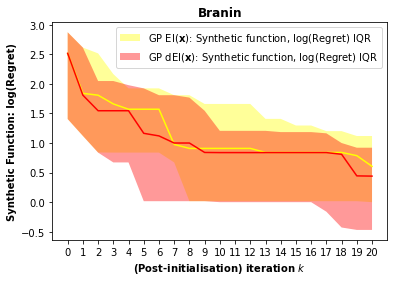

In [141]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$): Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


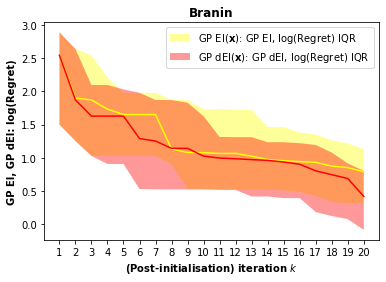

In [142]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approx_acqFuncMin, color = 'Yellow')
plt.plot(median_exact_acqFuncMin, color = 'Red')

xstar = np.arange(0, max_iter, step=1)
plt.fill_between(xstar, lower_approx_acqFuncMin, upper_approx_acqFuncMin, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$): GP EI, log(Regret) IQR')
plt.fill_between(xstar, lower_exact_acqFuncMin, upper_exact_acqFuncMin, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): GP dEI, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI, GP dEI: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()
